In [1]:
import numpy as np
import pandas as pd

# Modelling
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from collections import Counter
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFECV

# Visuals
import matplotlib. pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# helper functions
from sklearn.ensemble import RandomForestRegressor

def create_split_point(df, split_ratio=0.8):
    return int(len(df) * split_ratio) 

def evaluate_model(y_test, y_pred):
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)

    return mae, rmse, mape

def remove_highly_correlated_features(df, threshold):
    # Create correlation matrix
    corr_matrix = df.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Drop features 
    df = df.drop(to_drop, axis=1)
    
    return df

def plot_feature_importances(feature_importances, feature_names, df_name, top_n=15):
    # Convert feature_importances to a list
    importance_values = [feature_importances[feature] for feature in feature_names]
    
    # Only consider top_n features
    feature_names = feature_names[:top_n]
    importance_values = importance_values[:top_n]

    plt.figure(figsize=(14, 6))
    plt.barh(feature_names, importance_values)
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.tight_layout()  # Adjust layout
    plt.savefig(f'feature_importances_rf_{df_name}.jpg', format='jpg', dpi=300)
    plt.show()
    
# Conservative Hyperparameters due to high dimensionality to reduce overfitting
def perform_rfecv(df, df_name, features, target='total_admissions', model=RandomForestRegressor()):
    # Define training set
    X = df[features]
    y = df[target]

    # Scale the features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Create RFECV
    rfecv = RFECV(estimator=model, step=1, cv=TimeSeriesSplit(n_splits=3))
    
    rfecv.fit(X_scaled, y)

    # Get the feature ranking (1 is best)
    feature_ranks = rfecv.ranking_

    # Get important features (rank = 1)
    important_features = [X.columns[i] for i in range(len(feature_ranks)) if feature_ranks[i] == 1]

    # Fit the model to get feature importances
    model.fit(X_scaled[:, rfecv.support_], y)

    # Create a dictionary of feature importances
    feature_importances = dict(zip(important_features, model.feature_importances_))

    # Sort the dictionary by value in descending order and get the sorted keys
    important_features_sorted = [k for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)]

    # Plot the feature importances
    plot_feature_importances(feature_importances, important_features_sorted, df_name)

    print(f"For target {target}, the important features are: {important_features_sorted}\n")

    return important_features_sorted
        

In [3]:

""" 
While more data engineering needs to be done for the purpose of this notebook, 
this dataset has already been cleaned and carefully preprocessed. 
It includes daily patient-level data aggregated on a weekly basis 
from a previous study (https://www.mdpi.com/2075-4418/12/2/241) 
on cardiovascular diseases in Ludhiana (Punjab, India),
socio-economic and pollution data from CEIC Data, weather data 
from Visualcrossing Corporation, and Google search data
"""

df_adm = pd.read_csv('/kaggle/input/final-dataset-allfeatures/final_dataset_HA_Ludhiana_2017-2019_FINAL_NEW-V2.csv')
#df_adm = pd.read_csv('/kaggle/input/total-admissions-final-dataset/final_dataset_hospital_admission_Ludhiana_2017-2019_ALL-FEATURES_weekly_TEST.csv')
df_adm['date'] = pd.to_datetime(df_adm['date'], errors='raise')
df_adm.set_index('date', inplace=True)
#df_adm.drop('Unnamed: 0', axis=1, inplace=True)
df_adm.dropna(inplace=True)
df_adm.rename(columns={'search_HeroDMCHeartInstitute': 'search_hospital'}, inplace=True)

# 1. EDA 

In [4]:
df_adm.head(5)

,tempmax,Outcome_EXPIRY_sum,Outcome_DAMA_sum,Outcome_DISCHARGE_sum,SMOKING__sum,ALCOHOL_sum,DM_sum,HTN_sum,PRIOR_CMP_sum,readmissions_sum,...,cpi_health_PoP,cpi_Food_Beverages_PoP,cpi_health_YoY,vehicles_units_PoP,cpi_FaB,cpi_health,cpi_tobacco_intoxicants,vehicles_units,cpi_tobacco_intoxicants_distributed,cpi_FaB_distributed
date,,,,,,,,,,,,,,,,,,,,,
2017-04-09,39.6,7,4,65,5,5,23,42,12,0,...,0.200965,0.135344,3.807947,-0.604067,128.682928,124.454328,143.041134,27020,36.275,33.275
2017-04-16,44.8,14,1,46,3,3,18,17,15,1,...,0.200965,0.135344,3.807947,-3.106219,128.579744,124.548453,143.394040,13709,36.275,33.275
2017-04-23,45.4,16,2,46,9,13,35,47,22,1,...,0.200965,0.135344,3.807947,23.771691,128.519017,124.643415,143.762900,12122,36.275,33.275
2017-04-30,40.5,8,9,145,20,25,80,87,31,2,...,0.200965,0.135344,3.807947,83.975225,130.000000,125.400000,142.100000,11646,36.350,33.375
2017-05-07,45.0,9,3,116,14,22,67,67,33,3,...,0.179426,-0.076923,4.293972,-8.615413,128.539860,124.835897,144.549615,11844,36.350,33.375


## 1.1 Descriptive Statistics

In [5]:
# Display the descriptive statistics for each variable
df_adm.describe().T

,count,mean,std,min,25%,50%,75%,max
tempmax,104.0,34.362500,7.860509,18.600000,27.275000,36.350000,40.100000,48.400
Outcome_EXPIRY_sum,104.0,10.471154,4.936405,2.000000,7.000000,10.000000,14.000000,26.000
Outcome_DAMA_sum,104.0,7.923077,4.870542,0.000000,4.000000,8.000000,11.250000,20.000
Outcome_DISCHARGE_sum,104.0,118.990385,24.878538,46.000000,107.500000,121.000000,134.750000,178.000
SMOKING__sum,104.0,7.173077,4.345385,0.000000,3.000000,7.000000,10.250000,20.000
...,...,...,...,...,...,...,...,...
cpi_health,104.0,131.512859,5.079716,124.454328,127.177556,130.669941,135.144206,144.100
cpi_tobacco_intoxicants,104.0,160.594182,10.265035,142.100000,155.398011,159.491396,163.888629,182.000
vehicles_units,104.0,13293.836538,3414.192887,8226.000000,11449.750000,12749.000000,14227.750000,30390.000
cpi_tobacco_intoxicants_distributed,104.0,35.790385,4.055362,29.240000,31.500000,37.450000,39.475000,40.875


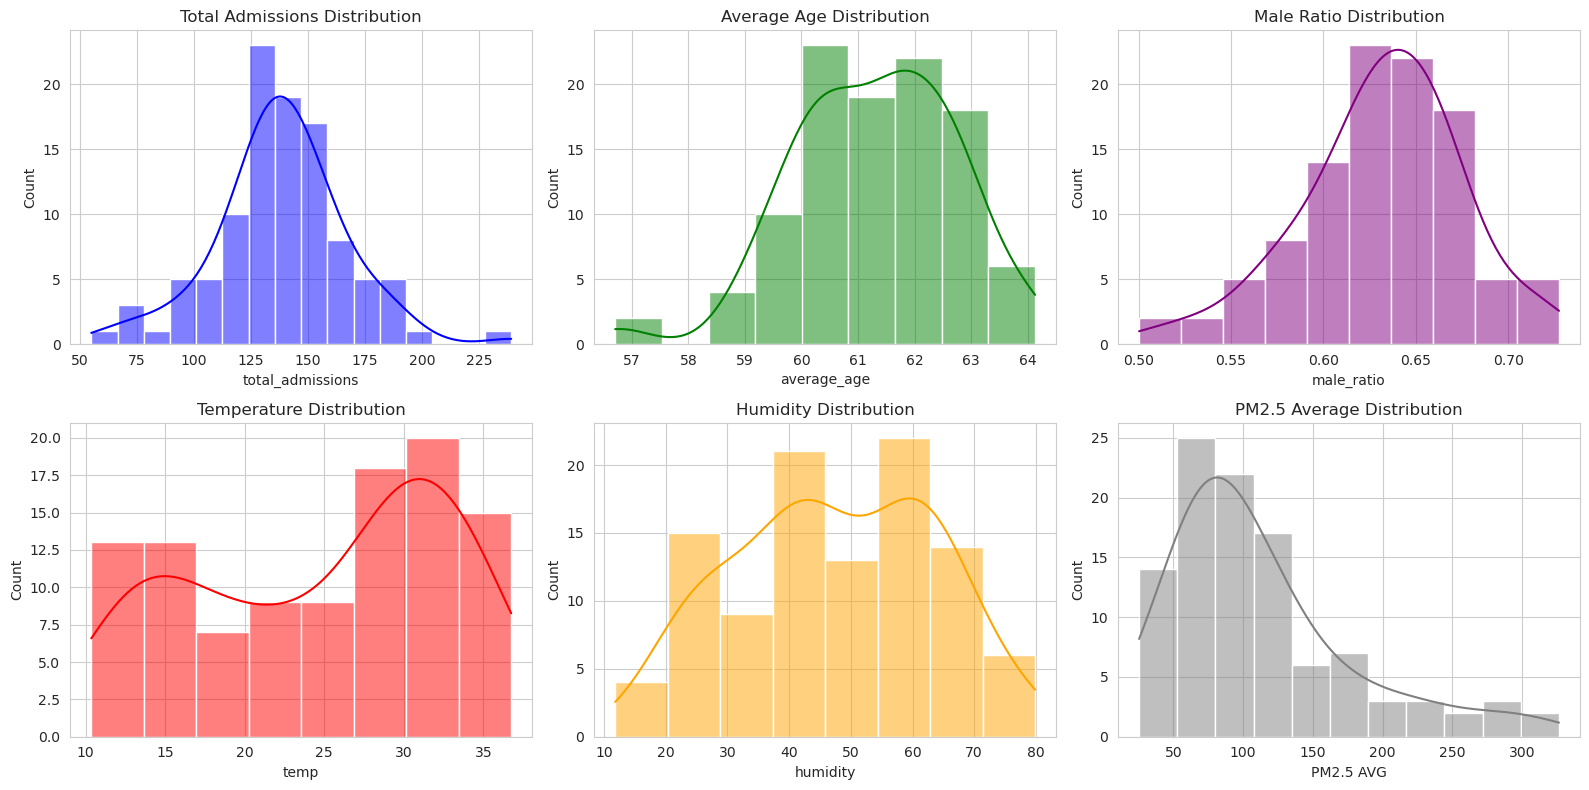

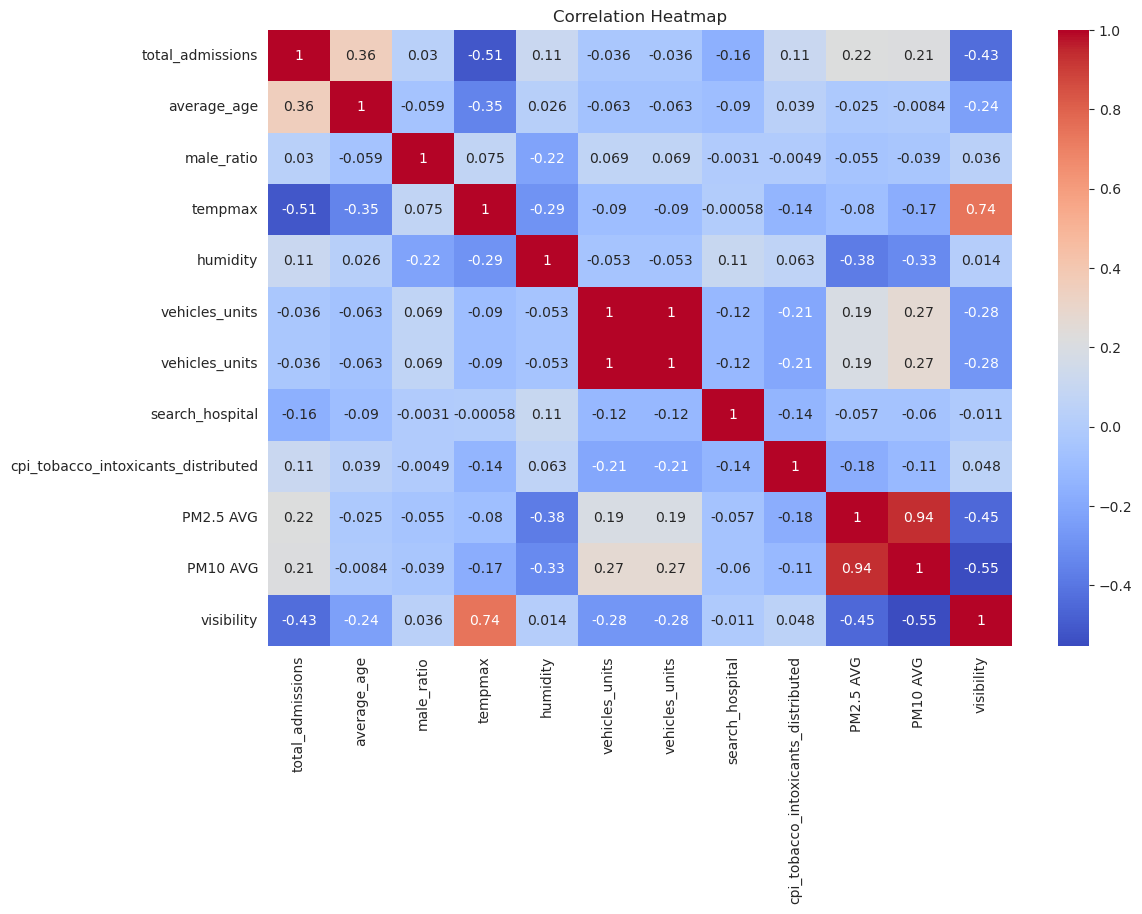

In [6]:
# Set the style of the plots
sns.set_style("whitegrid")

# Creating subplots
fig, ax = plt.subplots(2, 3, figsize=(16, 8))

# Plotting the distributions
sns.histplot(df_adm['total_admissions'], kde=True, ax=ax[0, 0], color='blue')
ax[0, 0].set_title('Total Admissions Distribution')

sns.histplot(df_adm['average_age'], kde=True, ax=ax[0, 1], color='green')
ax[0, 1].set_title('Average Age Distribution')

sns.histplot(df_adm['male_ratio'], kde=True, ax=ax[0, 2], color='purple')
ax[0, 2].set_title('Male Ratio Distribution')

sns.histplot(df_adm['temp'], kde=True, ax=ax[1, 0], color='red')
ax[1, 0].set_title('Temperature Distribution')

sns.histplot(df_adm['humidity'], kde=True, ax=ax[1, 1], color='orange')
ax[1, 1].set_title('Humidity Distribution')

sns.histplot(df_adm['PM2.5 AVG'], kde=True, ax=ax[1, 2], color='grey')
ax[1, 2].set_title('PM2.5 Average Distribution')

plt.tight_layout()
plt.savefig('distributions.jpg', format='jpg', dpi=300)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_adm[['total_admissions', 
                    'average_age', 
                    'male_ratio', 
                    'tempmax', 
                    'humidity',
                    'vehicles_units',
                    'vehicles_units',
                    'search_hospital',
                    'cpi_tobacco_intoxicants_distributed',
                    'PM2.5 AVG', 'PM10 AVG', 'visibility']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


## 1.2 Total Admissions Over Time

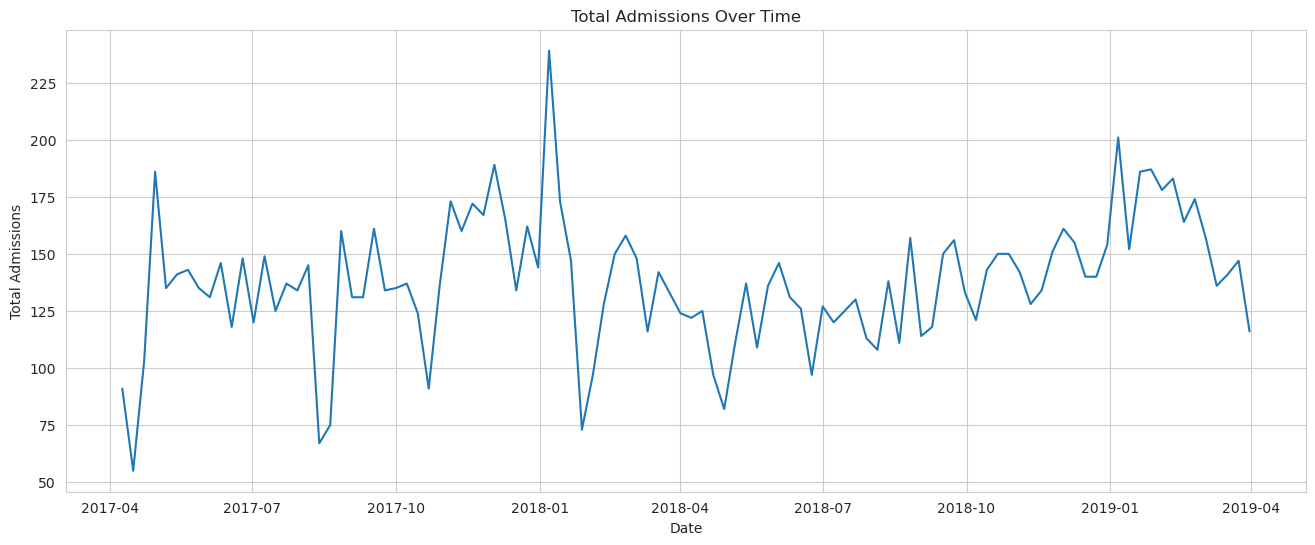

In [7]:
# Plot total admissions over time
plt.figure(figsize=(16, 6))
plt.plot(df_adm.index, df_adm['total_admissions'])
plt.xlabel('Date')
plt.ylabel('Total Admissions')
plt.title('Total Admissions Over Time')
plt.grid(True)
plt.savefig('total_admissions_over_time.jpg', format='jpg', dpi=300)
plt.show()


/tmp/ipykernel_20/1181787131.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


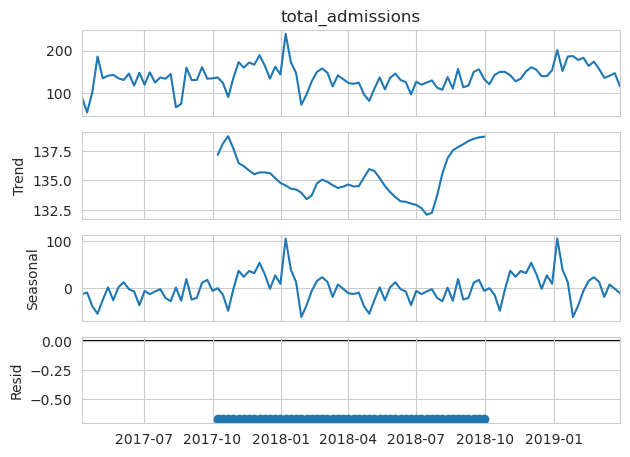

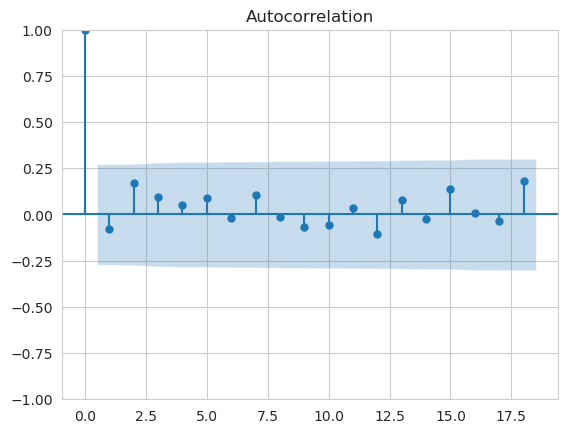

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
# Use the seasonal_decompose method from statsmodels.tsa.seasonal
result = seasonal_decompose(df_adm['total_admissions'], model='additive')

# Plot the original data, the trend, the seasonality, and the residuals 
result.plot()
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('seasonal_decompose.jpg', format='jpg', dpi=300)

plt.show()

# Check for autocorrelation in the residuals
plot_acf(result.resid.dropna())
plt.savefig('total_admissoins_autocorrelation.jpg', format='jpg', dpi=300)
plt.show()

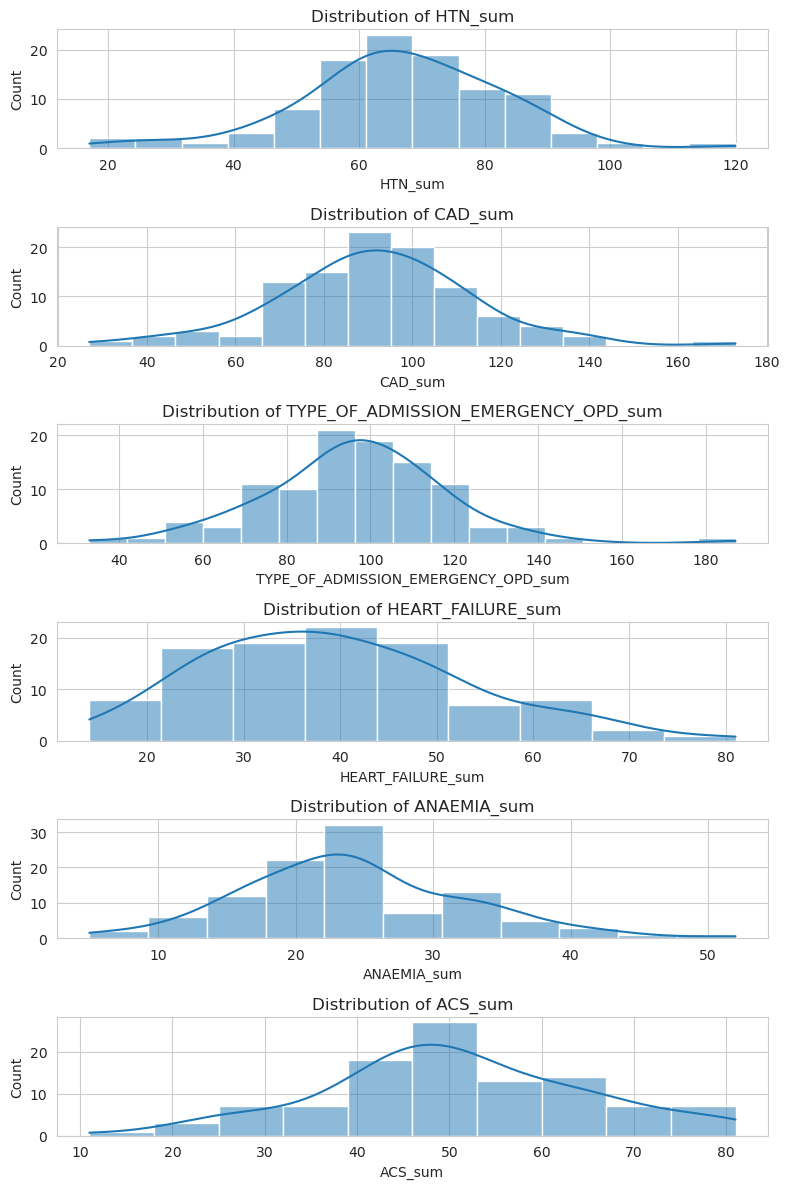

In [9]:
correlations_with_target = df_adm.corr()['total_admissions'].sort_values(ascending=False)

# Select top 10 correlated variables
top_corr_vars = correlations_with_target.index[1:7]

# Plot the dibstribution of these variables
fig, axs = plt.subplots(nrows=6, figsize=(8, 12))

for i, var in enumerate(top_corr_vars):
    sns.histplot(df_adm[var], kde=True, ax=axs[i])
    axs[i].set_xlabel(var)
    axs[i].set_title(f'Distribution of {var}')
    axs[i].grid(True)

plt.tight_layout()
# plt.savefig('distribution_patient_data.jpg', format='jpg', dpi=300)
plt.show()


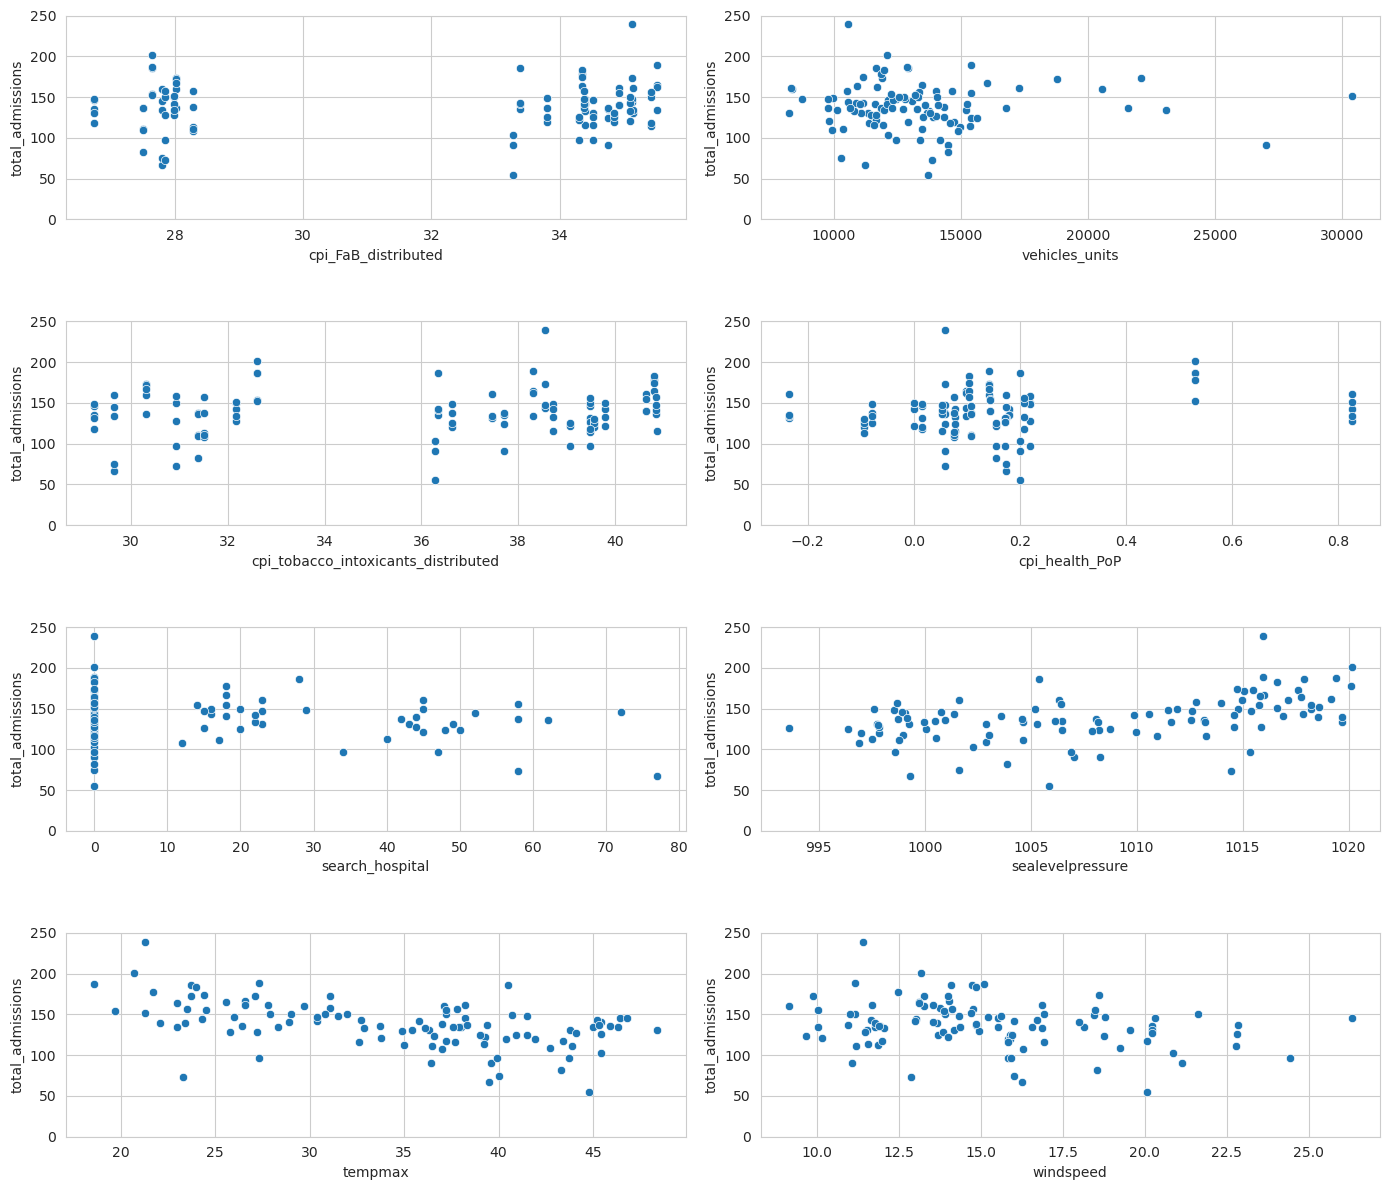

In [10]:
# List of features to explore
features = ['cpi_FaB_distributed', 'vehicles_units', 'cpi_tobacco_intoxicants_distributed', 'cpi_health_PoP', 'search_hospital', 'sealevelpressure', 'tempmax', 'windspeed']


# Plot scatter plots for each feature against the target variable
fig, axs = plt.subplots(4, 2, figsize=(14, 12))

for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    sns.scatterplot(data=df_adm, x=feature, y='total_admissions', ax=axs[row, col])
    #axs[row, col].set_title(f'Scatter plot of {feature} vs total_admissions')
    axs[row, col].set_ylim(0, 250)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # Adjust height space between subplots
plt.savefig('scatterplot_features.jpg', format='jpg', dpi=300)
plt.show()


# 2. Baseline 

The baseline prediction performance metrics (MAE, MAPE, RMSE) are based on a naive forecasting model, which simply uses the previous week's total admissions as the prediction for the current week.

    


In [11]:
# keep track of performances for both dataframes 
performances_all = {}
performances_cda = {}

In [12]:
# Make a copy of the dataframe
df_baseline = df_adm.copy()

# Create a new column for yesterday's admissions
df_baseline['lastweek_admissions'] = df_baseline['total_admissions'].shift(1)

# Drop the first row which will have NaN for lastweek's admissions
df_baseline = df_baseline.dropna()

# Calculate the baseline metrics
mae_bl = mean_absolute_error(df_baseline['total_admissions'], df_baseline['lastweek_admissions'])
rmse_bl = np.sqrt(mean_squared_error(df_baseline['total_admissions'], df_baseline['lastweek_admissions']))
mape_bl = mean_absolute_percentage_error(df_baseline['total_admissions'], df_baseline['lastweek_admissions'])

print(' –– ')
print('| 1 Week Prediction Naive Baseline (base on previous week\' s total hospital admissions):   ')
print('| MAE:  ', mae_bl)
print('| MAPE: ', mape_bl)
print('| RMSE: ', rmse_bl)
print(' –– ')

performances_all['Baseline'] = {'mae': mae_bl, 'rmse': rmse_bl, 'mape': mape_bl}
performances_cda['Baseline'] = {'mae': mae_bl, 'rmse': rmse_bl, 'mape': mape_bl,}


 –– 
| 1 Week Prediction Naive Baseline (base on previous week' s total hospital admissions):   
| MAE:   22.067961165048544
| MAPE:  0.17284374511754771
| RMSE:  29.36231651399394
 –– 


# 3 ARIMA

In [13]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

adf_test(df_adm['total_admissions'])


Results of Dickey-Fuller Test:
Test Statistic                -6.210243e+00
p-value                        5.530270e-08
#Lags Used                     0.000000e+00
Number of Observations Used    1.030000e+02
Critical Value (1%)           -3.495493e+00
Critical Value (5%)           -2.890037e+00
Critical Value (10%)          -2.581971e+00
dtype: float64


In [14]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [15]:
from pmdarima import auto_arima


split_point = create_split_point(df_adm)

train_data = df_adm['total_admissions'].iloc[:split_point]

model = auto_arima(train_data, 
                   start_p=0, start_q=0,
                   test='adf',       # use adftest to find optimal 'd'
                   max_p=3, max_q=3, # maximum p and q
                   m=1,              # frequency of series
                   d=None,           # let model determine 'd'
                   seasonal=False,   # No Seasonality
                   start_P=0, 
                   D=0, 
                   trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=800.711, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=795.739, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=785.484, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=798.744, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=780.274, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=778.418, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=783.751, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.43 sec

Best model:  

In [16]:
from PIL import Image, ImageDraw, ImageFont

# 1. Save the summary to a text file.
summary_str = str(model.summary())
with open('model_summary.txt', 'w') as f:
    f.write(summary_str)

# 2. Convert the text file to an image using Pillow.
def text_to_image(text_file, image_file):
    with open(text_file, 'r') as f:
        lines = f.readlines()

    # Determine the size of the image
    width = max([len(line) for line in lines]) * 10
    height = len(lines) * 20

    # Create an image
    img = Image.new('RGB', (width, height), color = 'white')
    d = ImageDraw.Draw(img)
    
    # Use a truetype font if available (this is just an example)
    # You might need to adjust the path to a font on your system or use the default font.
    try:
        font = ImageFont.truetype('times.ttf', 12)
    except IOError:
        font = ImageFont.load_default()
    
    # Draw text onto the image
    y = 0
    for line in lines:
        d.text((10, y), line, fill="black", font=font)
        y += 20

    img.save(image_file)

# Convert 'model_summary.txt' to 'model_summary.png'
text_to_image('model_summary.txt', 'model_summary.png')


In [17]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

df = df_adm.copy()

df.index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='W')

split_point = create_split_point(df)

train = df['total_admissions'].iloc[:split_point]
test = df['total_admissions'].iloc[split_point:]

order = (0,1,2)
model = ARIMA(train, order=order)  # order (p, d, q) found by auto_arima
model_fit = model.fit()

start_test = len(train)
end_test = start_test + len(test) - 1
predictions_test = model_fit.predict(start=start_test, end=end_test, typ='levels')

# Predict the training data
start_train = 0
end_train = len(train) - 1
predictions_train = model_fit.predict(start=start_train, end=end_train, typ='levels')

# Evaluate on test set
mae_test, rmse_test, mape_test = evaluate_model(test, predictions_test)

# Evaluate on train set
mae_train, rmse_train, mape_train = evaluate_model(train, predictions_train)
                               
# Store the metrics in a dictionary
performances_all['ARIMA'] = {
        'test_mae': mae_test,
        'train_mae': mae_train,
        'test_mape': mape_test,
        'train_mape': mape_train,  
        'test_rmse': rmse_test,
        'train_rmse': rmse_train,
        'predicts_test': predictions_test,
        'actuals_test': test.values,     
        'model_fit': model,
        'best-params': {'(p, d, q)': order}
    
}


# Store the metrics in a dictionary
performances_cda['ARIMA'] = {
        'test_mae': mae_test,
        'train_mae': mae_train,
        'test_mape': mape_test,
        'train_mape': mape_train,  
        'test_rmse': rmse_test,
        'train_rmse': rmse_train,
        'predicts_test': predictions_test,
        'actuals_test': test.values,     
        'model_fit': model,
        'best-params': {'p, d, q': order}
}

print(f'Test   ARIMA  RMSE : {rmse_test}')
print(f'Train  ARIMA  RMSE : {rmse_train}')
print(f'Test   ARIMA   MAE : {mae_test}')
print(f'Train  ARIMA   MAE : {mae_train}')
print(f'Test   ARIMA  MAPE : {mape_test}')
print(f'Train  ARIMA  MAPE : {mape_train}')

Test   ARIMA  RMSE : 30.818366590765724
Train  ARIMA  RMSE : 28.76094769432976
Test   ARIMA   MAE : 24.562243168089417
Train  ARIMA   MAE : 20.69852950057911
Test   ARIMA  MAPE : 0.14564748106779848
Train  ARIMA  MAPE : 0.17464740159714162


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


# 3 SARIMAX 

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarimax(df, target, features, order=(0,1,2), seasonal_order=(0, 0, 0, 7), split_ratio=0.8):
    
    df.index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='W')
    
    split_point = create_split_point(df, split_ratio)
    
    df_adjusted = df.copy()

    df_adjusted[features] = df[features].shift(1)
    
    # Remove the first row which will have NaN values for the shifted features
    df_adjusted.dropna(inplace=True) 

    train = df_adjusted.iloc[:split_point]
    test = df_adjusted.iloc[split_point:]

    # Fit the model
    model = SARIMAX(train[target], exog=train[features], order=order, seasonal_order=seasonal_order)  
    model_fit = model.fit(disp=False)
    
    start_test = len(train)
    end_test = start_test + len(test) - 1
    
    # Predict on the test set
    predictions_test = model_fit.predict(start=start_test, end=end_test, exog=test[features])
    # Predict the training data
    predictions_train = model_fit.predict(start=0, end=len(train)-1, exog=train[features])
    
    # Evaluate on test set
    mae_test, rmse_test, mape_test = evaluate_model(test[target], predictions_test)

    # Evaluate on train set
    mae_train, rmse_train, mape_train = evaluate_model(train[target], predictions_train)

    print(f'Test   SARIMAX  RMSE : {rmse_test}')
    print(f'Train  SARIMAX  RMSE : {rmse_train}')
    print(f'Test   SARIMAX  MAE : {mae_test}')
    print(f'Train  SARIMAX  MAE : {mae_train}')
    print(f'Test   SARIMAX  MAE : {mape_test}')
    print(f'Train  SARIMAX  MAE : {mape_train}')
    
    performance_dict = {
        'test_mae': mae_test, 
        'test_rmse': rmse_test,
        'test_mape': mape_test,
        'train_mae': mae_train,
        'train_mape': mape_train, 
        'train_rmse': rmse_train, 
        'predicts_test': predictions_test,
        'actuals_test': test['total_admissions'].values,
        'best-params': {'(p, d, q)': order, 'seasonal_order': seasonal_order}
        }
    
    return performance_dict


## 3.1 SARIMAX (including patient-level data)

In [19]:
# Set target and features
target = 'total_admissions'

features=['humidity', 'CKD_sum', 
          'tempmax', 'sun_duration', 
          'ANAEMIA_sum', 'HFNEF_sum', 
          'ATYPICAL_CHEST_PAIN_sum',
          'search_hospital', 'HTN_sum',
          'visibility','SMOKING__sum','readmissions_sum',
          'SEVERE_ANAEMIA_sum', 'ALCOHOL_sum', 
          'HEART_FAILURE_sum', 'Outcome_EXPIRY_sum', 'PM2.5 AVG', 
          'condition_rainy','average_age',
          'cpi_tobacco_intoxicants_distributed',
          'vehicles_units'
]


performance_dict = sarimax(df_adm, target, features, order=(0,1,2), seasonal_order=(0,0,0,7))

performances_all['SARIMAX'] = performance_dict


Test   SARIMAX  RMSE : 22.80382092991658
Train  SARIMAX  RMSE : 30.61562954207036
Test   SARIMAX  MAE : 19.517915446186002
Train  SARIMAX  MAE : 20.01734550776099
Test   SARIMAX  MAE : 0.11971989604427669
Train  SARIMAX  MAE : 0.18508628487156517


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## 3.2 SARIMAX (most predictive features cda: weather, pollution, google_search)

In [20]:
# Set target and features
target = 'total_admissions'

features=['tempmax', 
          'visibility', 
          'PM2.5 AVG', 
          'sun_duration',
          'search_hospital',
          'condition_rainy',
          'cpi_tobacco_intoxicants_distributed',
          'vehicles_units',
         
         ]


performance_dict = sarimax(df_adm, target, features, order=(0,1,2), seasonal_order=(0,0,0,7))

performances_cda['SARIMAX'] = performance_dict

Test   SARIMAX  RMSE : 25.904058925317177
Train  SARIMAX  RMSE : 36.04432919258593
Test   SARIMAX  MAE : 22.520732921532527
Train  SARIMAX  MAE : 20.30312598297341
Test   SARIMAX  MAE : 0.13812996795797103
Train  SARIMAX  MAE : 0.19428806106688204


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# 4. Machine Learning

## 4.1 Feature Engineering

In [21]:
# Create two dataframes for the two separate models
df_all = df_adm.copy()
df_cda = df_adm.copy()

# drop patient-level data for one dataframe
df_cda.drop(['DURATION_OF_STAY_median', 'duration_of_intensive_unit_stay_median',
       'Outcome_EXPIRY_sum', 'Outcome_DAMA_sum', 'Outcome_DISCHARGE_sum',
       'TLC_median', 'PLATELETS_median', 'GLUCOSE_median', 'UREA_median',
       'CREATININE_median', 'BNP_median', 'EF_median', 'HB_mean',
       'SMOKING__sum', 'ALCOHOL_sum', 'DM_sum', 'HTN_sum', 'CAD_sum',
       'PRIOR_CMP_sum', 'CKD_sum', 'SEVERE_ANAEMIA_sum', 'ANAEMIA_sum',
       'STABLE_ANGINA_sum', 'ACS_sum', 'STEMI_sum', 'ATYPICAL_CHEST_PAIN_sum',
       'HEART_FAILURE_sum', 'HFREF_sum', 'HFNEF_sum', 'VALVULAR_sum', 'TYPE_OF_ADMISSION_EMERGENCY_OPD_sum',
       'average_age', 'male_ratio', 'rural_ratio',
        'readmissions_sum','PM10 AVG'], axis=1, inplace=True)

# drop features that are not available for Kenya
#df_cda.drop(['PM10 AVG'], axis=1, inplace=True)
#df_adm.drop(['PM10 AVG'], axis=1, inplace=True)

def create_lagged_features(df, features, lag_count):
    df_lagged = pd.DataFrame(index=df.index)  # Create an empty DataFrame with the same index
    lagged_cols = []
    for feature in features:
        for i in range(1, lag_count + 1):
            new_col = df[feature].shift(i)
            new_col.name = feature + '_lag' + str(i)
            lagged_cols.append(new_col)
    df_lagged = pd.concat([df_lagged] + lagged_cols, axis=1)
    df_lagged['total_admissions'] = df['total_admissions']
    df_lagged = df_lagged.dropna()
    return df_lagged

# List of features to create lagged variables for
features_to_lag_cda = [col for col in df_cda.columns if col != 'total_admissions']
features_to_lag_all = [col for col in df_all.columns]

# Create lagged features for the past n days
df_cda = create_lagged_features(df_cda, features_to_lag_cda, 2)
df_all = create_lagged_features(df_all, features_to_lag_all, 2)


df_cda.dropna(inplace=True)
df_all.dropna(inplace=True)


def create_time_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['weekofyear'] = df.index.isocalendar().week.astype('int')
    return df

df_all = create_time_features(df_all)
df_cda = create_time_features(df_cda)


/tmp/ipykernel_20/2470896573.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagged['total_admissions'] = df['total_admissions']


## 4.2  Feature Selection

### 4.2.1 Filter Method: Correlation

In [22]:
df_tmp = remove_highly_correlated_features(df_all, threshold=0.85)
print('Variables highly correlated with target (all features): ')
df_tmp[df_tmp.columns].corr()['total_admissions'].sort_values(ascending=False).head(10)

Variables highly correlated with target (all features): 


total_admissions           1.000000
HEART_FAILURE_sum_lag1     0.457557
CKD_sum_lag1               0.408774
ACS_sum_lag1               0.397333
Outcome_DAMA_sum_lag1      0.397220
ANAEMIA_sum_lag1           0.381627
HTN_sum_lag1               0.381497
SEVERE_ANAEMIA_sum_lag1    0.380905
HEART_FAILURE_sum_lag2     0.374638
ACS_sum_lag2               0.357727
Name: total_admissions, dtype: float64

In [23]:
df_tmp = remove_highly_correlated_features(df_cda, threshold=0.9)
print('Variables highly correlated with target (CDA features): ')
df_tmp[df_tmp.columns].corr()['total_admissions'].sort_values(ascending=False).tail(10)

Variables highly correlated with target (CDA features): 


cloudcover_lag1        -0.085408
windspeed_lag2         -0.217821
windspeed_lag1         -0.256992
search_hospital_lag1   -0.274406
condition_rainy_lag2   -0.275792
condition_rainy_lag1   -0.276991
dew_lag1               -0.357211
visibility_lag1        -0.416738
tempmax_lag1           -0.457809
visibility_lag2        -0.474889
Name: total_admissions, dtype: float64

In [24]:
df_cda[df_cda.columns].corr()['total_admissions'].sort_values(ascending=False).head(5)

total_admissions                1.000000
sealevelpressure_lag1           0.486940
sealevelpressure_lag2           0.451544
cpi_tobacco_intoxicants_lag1    0.306382
cpi_tobacco_intoxicants_lag2    0.302181
Name: total_admissions, dtype: float64

In [25]:
df_tmp = remove_highly_correlated_features(df_cda, threshold=0.8)

# Get correlation series
corr_series = df_tmp[df_tmp.columns].corr()['total_admissions']

# Get top 5 most positively correlated features
top_pos = corr_series.nlargest(6)[1:]  # The largest one will be 'total_admissions' itself, so we ignore it

# Get top 5 most negatively correlated features
top_neg = corr_series.nsmallest(5)

# Concatenate both Series and write to Excel
top_corr = pd.concat([top_pos, top_neg])
top_corr.to_excel("top_correlations.xlsx")


### 4.2.2 Filter Method: Mutual Information

All features: 
Index(['SMOKING__sum_lag1', 'DM_sum_lag1', 'ATYPICAL_CHEST_PAIN_sum_lag2',
       'sealevelpressure_lag1', 'sealevelpressure_lag2', 'PM10 AVG_lag1',
       'visibility_lag1', 'UREA_median_lag1', 'uvindex_lag1',
       'sun_duration_lag1', 'cpi_health_lag1', 'cpi_health_lag2',
       'vehicles_units_lag1', 'month', 'weekofyear'],
      dtype='object')


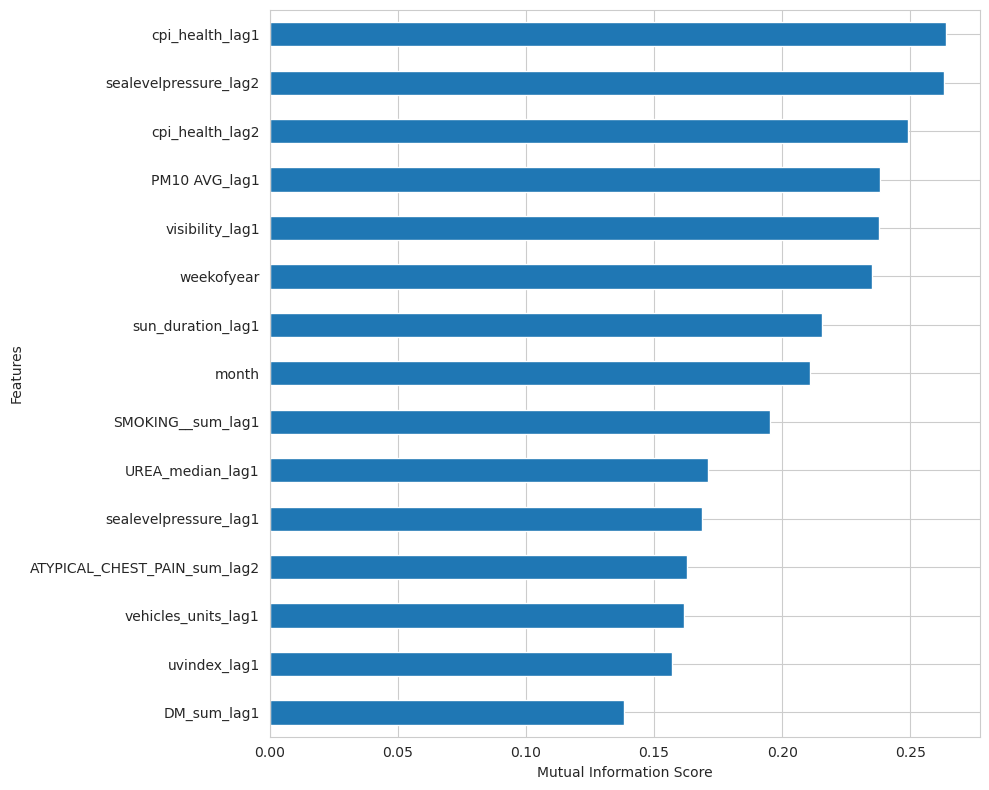

CDA features: 
Index(['temp_lag1', 'sealevelpressure_lag1', 'sealevelpressure_lag2',
       'PM2.5 AVG_lag2', 'visibility_lag1', 'uvindex_lag1',
       'sun_duration_lag1', 'sun_duration_lag2', 'cpi_Food_Beverages_PoP_lag2',
       'cpi_health_lag1', 'cpi_health_lag2', 'vehicles_units_lag1',
       'cpi_FaB_distributed_lag2', 'month', 'weekofyear'],
      dtype='object')


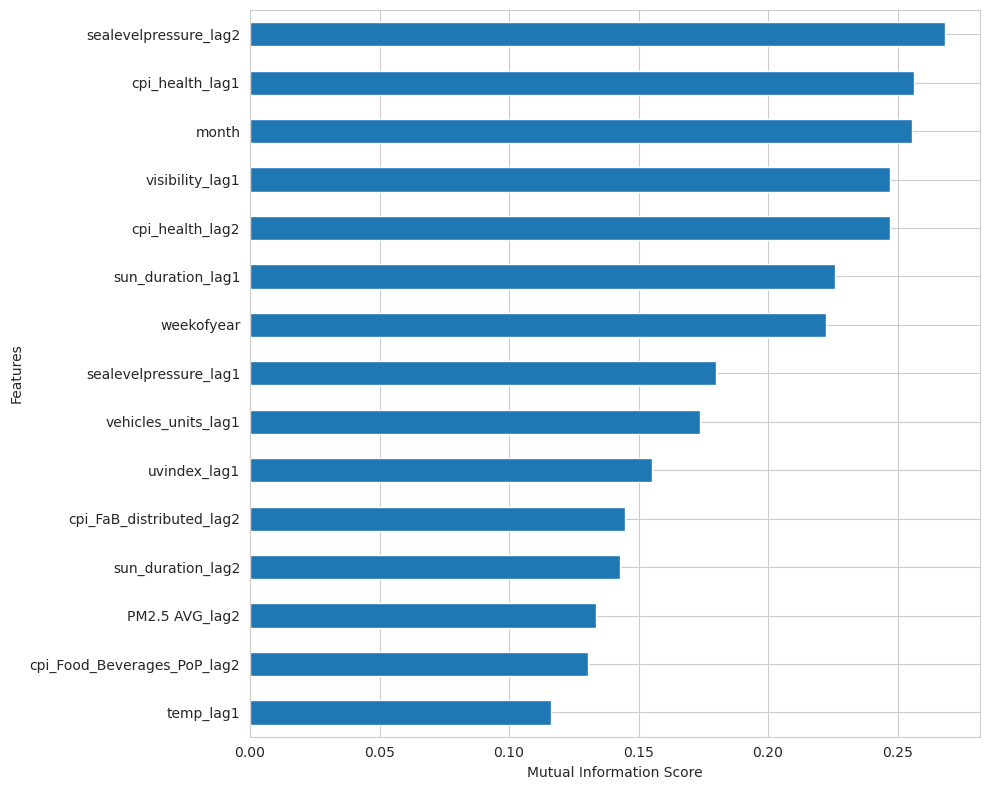

In [26]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
import matplotlib.pyplot as plt

def mutual_info(df, df_name):
    # Split the data into training and testing sets maintaining the temporal order
    train_size = int(0.8 * len(df))
    X_train, X_test = df.drop('total_admissions', axis=1)[:train_size], df.drop('total_admissions', axis=1)[train_size:]
    y_train, y_test = df['total_admissions'][:train_size], df['total_admissions'][train_size:]

    # Select the 15 best features based on mutual information
    selector = SelectKBest(mutual_info_regression, k=15)

    # Fit the selector to the training data
    selector.fit(X_train, y_train)

    # Get the boolean mask of features selected
    mask = selector.get_support()

    # Get the reduced dataframe
    reduced_X_train = X_train.loc[:, mask]

    print(reduced_X_train.columns)

    # Get the scores from the selector for selected features and create a series
    scores = pd.Series(selector.scores_[mask], index=reduced_X_train.columns)

    # Sort the scores in ascending order
    scores = scores.sort_values(ascending=True)

    # Plot the scores
    plt.figure(figsize=(10, 8))
    scores.plot(kind='barh')
    #plt.title(f'Feature Importance Ranked by Mutual Information for {df_name} Features')
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Features')
    plt.tight_layout()  # Adjust layout
    plt.savefig(f'mutual_info_{df_name}.jpg', format='jpg', dpi=300)
    plt.show()

print('All features: ')    
mutual_info(df_all, 'All')

print('CDA features: ')
mutual_info(df_cda, 'CDA')


### 4.2.3 Wrapper Method: Recursive Feature Elimination CV

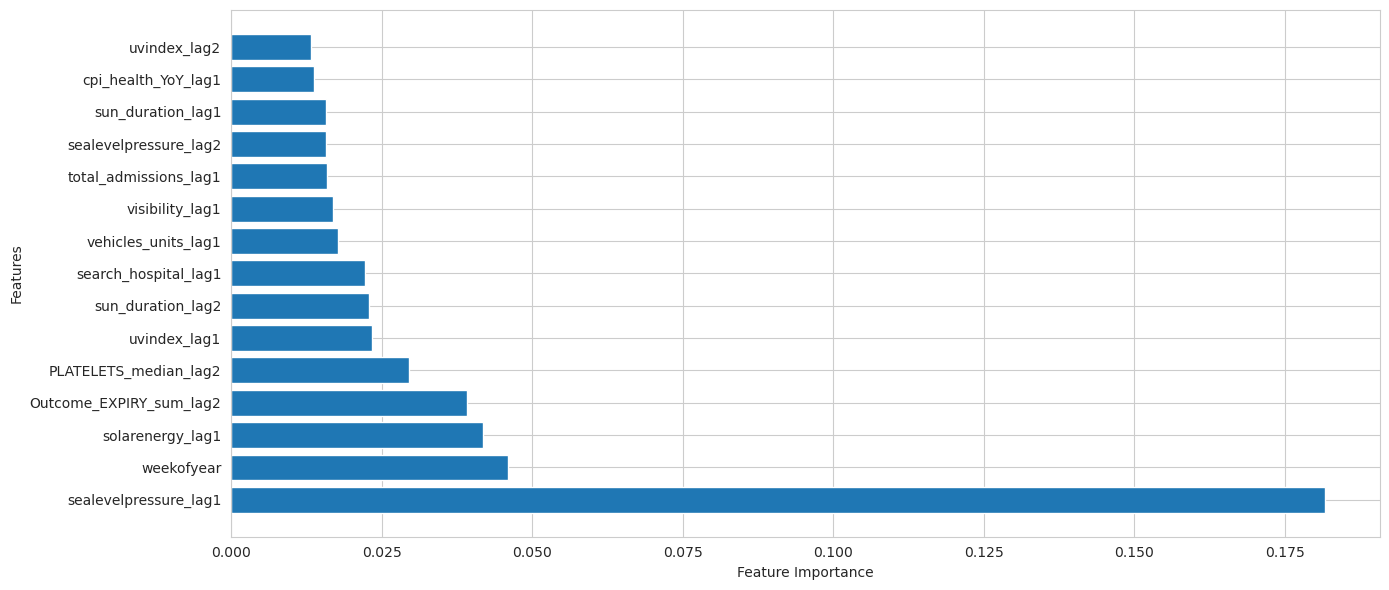

For target total_admissions, the important features are: ['sealevelpressure_lag1', 'weekofyear', 'solarenergy_lag1', 'Outcome_EXPIRY_sum_lag2', 'PLATELETS_median_lag2', 'uvindex_lag1', 'sun_duration_lag2', 'search_hospital_lag1', 'vehicles_units_lag1', 'visibility_lag1', 'total_admissions_lag1', 'sealevelpressure_lag2', 'sun_duration_lag1', 'cpi_health_YoY_lag1', 'uvindex_lag2', 'tempmin_lag2', 'vehicles_units_lag2', 'CKD_sum_lag2', 'SMOKING__sum_lag1', 'visibility_lag2', 'duration_of_intensive_unit_stay_median_lag1', 'Outcome_DISCHARGE_sum_lag1', 'TYPE_OF_ADMISSION_EMERGENCY_OPD_sum_lag1', 'DURATION_OF_STAY_median_lag1', 'HFREF_sum_lag2', 'HEART_FAILURE_sum_lag1', 'cpi_health_YoY_lag2', 'HTN_sum_lag2', 'total_admissions_lag2', 'cloudcover_lag2', 'HB_mean_lag2', 'male_ratio_lag2', 'dew_lag1', 'STEMI_sum_lag1', 'windspeed_lag1', 'cpi_health_lag1', 'cpi_Food_Beverages_PoP_lag1', 'GLUCOSE_median_lag1', 'HEART_FAILURE_sum_lag2', 'ANAEMIA_sum_lag2', 'ACS_sum_lag1', 'Outcome_EXPIRY_sum_lag1'

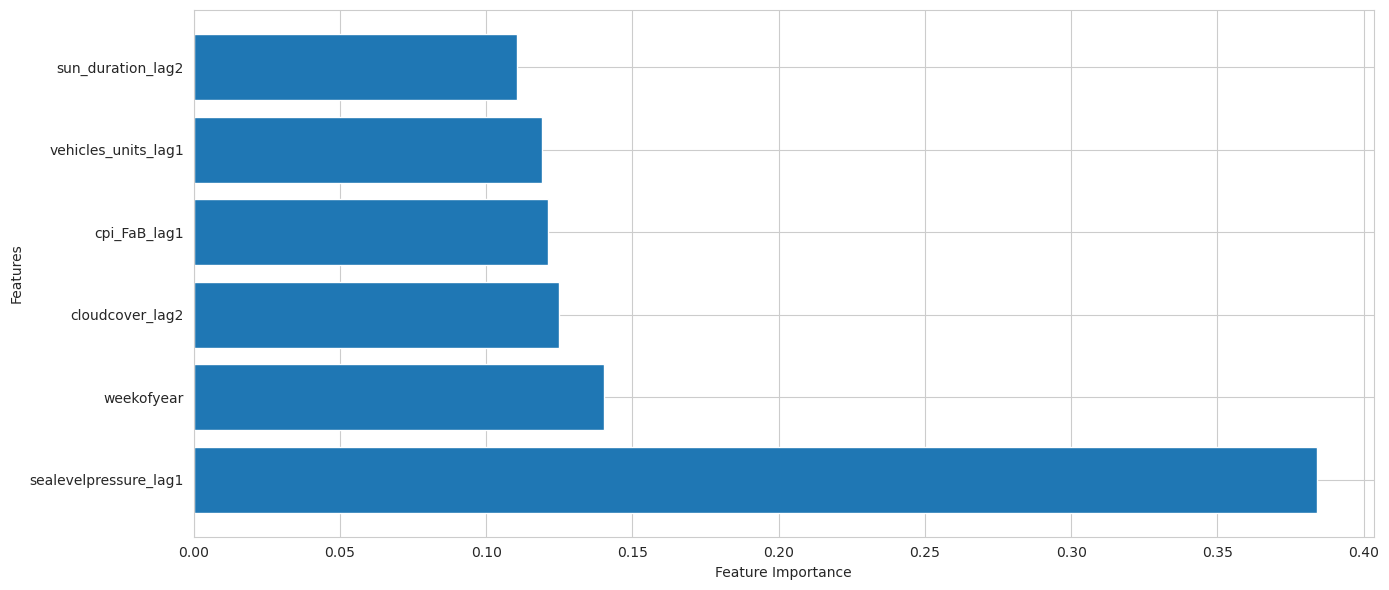

For target total_admissions, the important features are: ['sealevelpressure_lag1', 'weekofyear', 'cloudcover_lag2', 'cpi_FaB_lag1', 'vehicles_units_lag1', 'sun_duration_lag2']



In [27]:
def call_rfecv(df, df_name, features=None):
    #final_features_all = select_important_features(rfecv_features_all, [value for value in dfs_all.values()])
    if features is None:
        features=df.drop('total_admissions', axis=1).columns
        features=features.tolist()

    rfes = perform_rfecv(df,  df_name, features)


call_rfecv(df_all, 'ALL')    
call_rfecv(df_cda, 'CDA')



In [28]:
def lags_list(v_list, x=1, n=8):
    lags = []
    for variable in v_list:
        for i in range(x, n):
            lags.append(variable + '_lag' + str(i))
    return lags

lagged_features_all = lags_list(['total_admissions', 
                                 'search_hospital',
                                 'sealevelpressure',
                                 'PM2.5 AVG',
                                 'condition_rainy',
                                 'ACS_sum',
                                 'SMOKING__sum',
                                 'tempmax',
                                 'windspeed',
                                 'sun_duration',
                                 'cpi_tobacco_intoxicants_distributed',
                                 'vehicles_units',
                                 'TYPE_OF_ADMISSION_EMERGENCY_OPD_sum',
                                 
                                 ], 1,2) + [
                                          'weekofyear', 
                                          'month',
                                          'sealevelpressure_lag2',
                                          'cpi_FaB_distributed_lag2']



lagged_features_cda = lags_list(['tempmax',
                                 'sealevelpressure',
                                 'sun_duration',
                                 'search_hospital',
                                 'PM2.5 AVG',
                                 'windspeed',
                                 'cpi_tobacco_intoxicants_distributed',
                                 'vehicles_units',
                                 'condition_rainy',
                                 ], 1,2) + [
                                          'weekofyear',
                                          'month',
                                          'sealevelpressure_lag2',
                                          'cpi_FaB_distributed_lag2']


## 4.3 Model Training with 80/20 Train-Test Split (time order preserved)

In [29]:
from xgboost import callback

def train_simple_model(df, features, target, model, split_ratio=0.8, post=True):
    model_name = type(model).__name__

    # Initialize a scaler object 
    scaler = StandardScaler()
    
    # Determine Splitpoint for Train Size
    split_point = create_split_point(df, split_ratio=split_ratio)
    
    # Split the data
    X_train, X_test = df[features][:split_point], df[features][split_point:]
    y_train, y_test = df[target][:split_point], df[target][split_point:]
    
    # not strictly necessary but removes warning during optuna tuning
    y_train, y_test = y_train.squeeze(), y_test.squeeze()
    
    # Scale the features
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
        
    if isinstance(model, XGBRegressor):
        model.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_test, y_test)],
                      verbose=False)
    else:
        model.fit(X_train, y_train)
        
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    # Evaluate on test set
    mae_test, rmse_test, mape_test = evaluate_model(y_test, y_pred_test)

    # Evaluate on train set
    mae_train, rmse_train, mape_train = evaluate_model(y_train, y_pred_train)
    
    # Calculate residuals
    residuals_test = y_test.values - y_pred_test
    residuals_train = y_train.values - y_pred_train
                                   
    # Store the metrics in a dictionary
    performance_dict = {
            'test_mae': mae_test,
            'train_mae': mae_train,
            'test_mape': mape_test,
            'train_mape': mape_train,  
            'test_rmse': rmse_test,
            'train_rmse': rmse_train,
            'residuals_test': residuals_test,
            'residuals_train': residuals_train,
            'predicts_test': y_pred_test,
            'actuals_test': y_test.values, 
            'predicts_train': y_pred_train,
            'actuals_train': y_train.values,
            'model_fit': model,
    }
    
    if post == True:
        print(f"Performance for model {model_name}:")
        print()
        print(f"Test MAE: {mae_test}")
        print(f"Train MAE: {mae_train}")
        print(f"Test MAPE: {mape_test}")
        print(f"Train MAPE: {mape_train}")
        print(f"Test RMSE: {rmse_test}")
        print(f"Train RMSE: {rmse_train}")
        print("-------------------------------------------------------------------------")
        
    return performance_dict


In [30]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor


configs = {
    
    'df_all': {
            'df': df_all,
            'target_var': 'total_admissions',
            'models': [
                {'model': ElasticNet, 'features': lagged_features_all, 'best_params': None},
                {'model': Ridge, 'features': lagged_features_all, 'best_params': None},
                {'model': SVR, 'features': lagged_features_all, 'best_params': None},
                {'model': KNeighborsRegressor, 'features': lagged_features_all, 'best_params': None},
                {'model': RandomForestRegressor, 'features': lagged_features_all, 'best_params': None},
                {'model': XGBRegressor, 'features': lagged_features_all, 'best_params':None},        
            ],
    },
    
    'df_cda': {
            'df': df_cda,
            'target_var': 'total_admissions',
            'models': [
                {'model': ElasticNet, 'features': lagged_features_cda, 'best_params': None},
                {'model': Ridge, 'features': lagged_features_cda, 'best_params': None},
                {'model': SVR, 'features': lagged_features_cda, 'best_params': None},
                {'model': KNeighborsRegressor, 'features': lagged_features_cda, 'best_params': None},
                {'model': RandomForestRegressor, 'features': lagged_features_cda, 'best_params': None},
                {'model': XGBRegressor, 'features': lagged_features_cda, 'best_params':None},
            ],
    }
}

performances_all['untuned'] = {}
performances_all['tuned'] = {}
performances_cda['untuned'] = {}
performances_cda['tuned'] = {}


### 4.3.1 Training on best feature set including patient level variables on  all features

In [31]:
# Loop over all the models in the config
for config in configs['df_all']['models']:
    model_class = config['model']
    model = model_class()
    features = config['features']
    performance_dict = train_simple_model(df_all, features, 'total_admissions', model)
    performances_all['untuned'][model_class.__name__] = performance_dict

Performance for model ElasticNet:

Test MAE: 17.45405179331937
Train MAE: 15.837844989906545
Test MAPE: 0.10597840197943824
Train MAPE: 0.1308102482852784
Test RMSE: 22.083020952693666
Train RMSE: 22.501277396981347
-------------------------------------------------------------------------
Performance for model Ridge:

Test MAE: 19.621479547978264
Train MAE: 15.510806884683944
Test MAPE: 0.118820891635997
Train MAPE: 0.12632518644950483
Test RMSE: 24.049655500559645
Train RMSE: 21.80556464928963
-------------------------------------------------------------------------
Performance for model SVR:

Test MAE: 23.023744159331827
Train MAE: 17.851870173038037
Test MAPE: 0.1365412886000005
Train MAPE: 0.14799604918097695
Test RMSE: 29.229724652751838
Train RMSE: 25.493547112670527
-------------------------------------------------------------------------
Performance for model KNeighborsRegressor:

Test MAE: 23.314285714285713
Train MAE: 14.674074074074072
Test MAPE: 0.14130109120693493
Train MA

### 4.3.2 Training on best feature set excluding patient level variables

In [32]:
# Loop over all the models in the config
for config in configs['df_cda']['models']:
    model_class = config['model']
    model = model_class()
    features = config['features']
    performance_dict = train_simple_model(df_cda, features, 'total_admissions', model)
    performances_cda['untuned'][model_class.__name__] = performance_dict

Performance for model ElasticNet:

Test MAE: 18.623712444861592
Train MAE: 16.29016770431303
Test MAPE: 0.11314128703047406
Train MAPE: 0.1354536680847994
Test RMSE: 23.44786265054896
Train RMSE: 22.940661375847807
-------------------------------------------------------------------------
Performance for model Ridge:

Test MAE: 19.10740119743502
Train MAE: 16.079611467796266
Test MAPE: 0.11778085768721994
Train MAPE: 0.13225049504528338
Test RMSE: 22.75082921400697
Train RMSE: 22.310047520669723
-------------------------------------------------------------------------
Performance for model SVR:

Test MAE: 22.910195085805768
Train MAE: 17.997305731115055
Test MAPE: 0.1357089172767912
Train MAPE: 0.14950386960504564
Test RMSE: 29.219918406605625
Train RMSE: 25.5162951385516
-------------------------------------------------------------------------
Performance for model KNeighborsRegressor:

Test MAE: 22.16190476190476
Train MAE: 14.985185185185184
Test MAPE: 0.13551595543409276
Train MAPE:

## 5 Hyperparameter Tuning

In [33]:
# Define the models and their respective hyperparameter spaces
model_dict = {
    
    
     'XGBRegressor': {
        'model': XGBRegressor,
        'features': {'df_all': lagged_features_all, 'df_cda': lagged_features_cda},
        'params': {
            'n_estimators': ('int', (100, 600)),
            'max_depth': ('int', (1, 12)),
            'learning_rate': ('float', (0.1, 4), 'log'),  # use suggest_float with 'log' distribution
            'gamma': ('float', (0.1, 6)),
            'subsample': ('float', (0.5, 1.0)),
            'colsample_bytree': ('float', (0.1, 1.0)),
            'reg_alpha': ('float', (1, 8)),  # L1 regularization
            'reg_lambda': ('float', (1, 6.0)),  # L2 regularization
            }
    },
    
    'Ridge': {
        'model': Ridge,
        'features': {'df_all': lagged_features_all, 'df_cda': lagged_features_cda},
        'params': {
            'alpha': ('loguniform', (1e-3, 10.0), 'log'),  # use suggest_float with 'log' distribution
            'fit_intercept': ('categorical', [True, False]),
            #'normalize': ('categorical', [True, False]),
            'solver': ('categorical', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
        }
    },
    
    'RandomForestRegressor': {
        'model': RandomForestRegressor,
        'features': {'df_all': lagged_features_all, 'df_cda': lagged_features_cda},
        'params': {
            'n_estimators': ('int', (100, 300)),
            'max_depth': ('int', (1, 10)),
            'min_samples_split': ('int', (2, 10)),
            'min_samples_leaf': ('int', (1, 10)),
            }
    },
    
    
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor,
        'features': {'df_all': lagged_features_all, 'df_cda': lagged_features_cda},
        'params': {
            'n_neighbors': ('int', (2, 10)),
            'weights': ('categorical', ['uniform', 'distance']),
            'algorithm': ('categorical', ['auto', 'ball_tree', 'kd_tree', 'brute']),
            }
    },
    
    'ElasticNet': {
        'model': ElasticNet,
        'features': {'df_all': lagged_features_all, 'df_cda': lagged_features_cda},
        'params': {
            'alpha': ('loguniform', (1e-3, 10.0), 'log'),  # use suggest_float with 'log' distribution
            'l1_ratio': ('float', (0.0, 1.0)),
            'fit_intercept': ('categorical', [True, False]),
            #'normalize': ('categorical', [True, False]),
            'precompute': ('categorical', [True, False]),
            'warm_start': ('categorical', [True, False]),
            'positive': ('categorical', [True, False]),
            'selection': ('categorical', ['cyclic', 'random']),
            'max_iter': ('int', (1000, 60000)),  # increase the max_iter range
            }
    },
    
    'SVR': {
    'model': SVR,
    'features': {'df_all': lagged_features_all, 'df_cda': lagged_features_cda},
    'params': {
        'kernel': ('categorical', ['linear', 'poly', 'rbf', 'sigmoid']),
        'degree': ('int', (1, 10)),  # degree of the polynomial kernel function (‘poly’)
        'gamma': ('loguniform', (1e-6, 1.0), 'log'),  # kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
        'coef0': ('float', (0.0, 10.0)),  # independent term in kernel function. It is only significant in ‘poly’ and ‘sigmoid’
        'tol': ('float', (1e-6, 1e-2)),  # tolerance for stopping criterion
        'C': ('loguniform', (1e-2, 1e2), 'log'),  # regularization parameter
        'epsilon': ('float', (0.01, 0.1)),  # epsilon in the epsilon-SVR model
        'shrinking': ('categorical', [True, False]),  # whether to use the shrinking heuristic
        'cache_size': ('float', (200.0, 500.0)),  # size of the kernel cache (in MB)
        'verbose': ('categorical', [False]),  # set verbosity of the model
        'max_iter': ('int', (20000, 60000)),  # hard limit on iterations within solver
        }

    }

}

In [34]:
import optuna
import optuna.logging
import warnings
from sklearn.exceptions import ConvergenceWarning

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Set a random seed for reproducibility
np.random.seed(0)

# Define the objective function
def objective(trial, model_key, df, target, features):
    model_class = model_dict[model_key]['model']
    model_params = model_dict[model_key]['params']
    
    # Define the hyperparameters for the current model
    kwargs = {}
    for param_name, items in model_params.items():
        type, options = items[0], items[1]
        if len(items) > 2 and items[2] == 'log':
            kwargs[param_name] = trial.suggest_float(param_name, *options, log=True)
        elif type == 'float':
            kwargs[param_name] = trial.suggest_float(param_name, *options)
        elif type == 'int':
            kwargs[param_name] = trial.suggest_int(param_name, *options)
        elif type == 'categorical':
            kwargs[param_name] = trial.suggest_categorical(param_name, options)
        if model_class == XGBRegressor:
            early_stopping = callback.EarlyStopping(rounds=30, metric_name="mae", data_name="validation_0")
            kwargs['callbacks'] = [early_stopping]
            kwargs['objective'] = 'reg:squarederror'
            kwargs['eval_metric'] = 'mae'

    # Instantiate and train the model
    model = model_class(**kwargs)
    performance_dict = train_simple_model(df, features, target, model, post=False, split_ratio=.8)
    
    # Add Custom penalty
    """
    If train_mape is less than test_mape, the model is underfitting.
    In this case, train_mape / test_mape is less than 1, 
    so train_mape / test_mape - 1 is negative. 
    Taking the absolute value makes the penalty positive.

    If train_mape is greater than test_mape, 
    the model is overfitting. In this case, 
    train_mape / test_mape is greater than 1, 
    so train_mape / test_mape - 1 is positive. 
    Taking the absolute value does not change the penalty.
    """
    test_score = performance_dict['test_mape']
    train_score = performance_dict['train_mape']
    overfit_penalty = abs(train_score / test_score - 1) + test_score
    
    final_score = test_score * (1 + overfit_penalty)
    
    return final_score

### 5.1 Hyperparameter Tuning Models (all features)

In [35]:
# Loop through the models and perform hyperparameter optimization for each one
best_models_all={}
for model_key, sets in model_dict.items():
    print(f'Tuning model {model_key}....')
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        study = optuna.create_study(direction='minimize')  # we want to minimize MAE
        
        # warmup for XGBRegressor 
        #if model_key == 'XGBRegressor':  
         #   study.enqueue_trial({'n_estimators': 120, 'max_depth': 1, 'learning_rate': 0.2039295128852198, 'gamma': 5.571377962808105, 'subsample': 0.9069138622126549, 'colsample_bytree': 0.1642066555051201, 'reg_alpha': 1.3729375739485172, 'reg_lambda': 1.4565861810569083})
        
        study.optimize(lambda trial: objective(trial, model_key, df_all, ['total_admissions'], sets['features']['df_all']), n_trials=3500)
    score = study.best_trial.value
    params = study.best_trial.params
    
    # cache the results
    best_models_all[model_key] = {'best_score': study.best_trial.value, 'best_params': study.best_trial.params}
    print('Best trial for {}: score {}, params {}\n'.format(model_key, score, params))
        
# update configs
for config in configs['df_all']['models']:
    model_class = config['model']
    model_name = model_class.__name__
    if model_name in best_models_all:
        # get the tuned models parameters
        best_params = best_models_all[model_name]['best_params']
        
        # create instance of model with new parameters
        if best_params is not None:
            model = model_class(**best_params)
        else:
            model = model_class()
            
        # train model and retrieve performance
        features = config['features']
        performance_dict = train_simple_model(df_all, lagged_features_all, 'total_admissions', model)
        
        # save paramters and performance in respective dictionaries
        config['best_params'] = best_params
        performance_dict['best_params'] = best_params
        performances_all['tuned'][model_name] = performance_dict

Tuning model XGBRegressor....
Best trial for XGBRegressor: score 0.0824192644218702, params {'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.25726226853422673, 'gamma': 1.9324104018697206, 'subsample': 0.9408510620551351, 'colsample_bytree': 0.15811261176589833, 'reg_alpha': 6.978991275981512, 'reg_lambda': 1.4004655324110127}

Tuning model Ridge....
Best trial for Ridge: score 0.1396600457541509, params {'alpha': 0.0010049478974808255, 'fit_intercept': True, 'solver': 'sparse_cg'}

Tuning model RandomForestRegressor....
Best trial for RandomForestRegressor: score 0.0982453987158902, params {'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 4}

Tuning model KNeighborsRegressor....
Best trial for KNeighborsRegressor: score 0.1430248552982924, params {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'ball_tree'}

Tuning model ElasticNet....
Best trial for ElasticNet: score 0.13815136007446055, params {'alpha': 0.6401217713175151, 'l1_ratio': 0.

### 5.2 Hyperparameter Tuning Models (cda features)

In [36]:
best_models_cda = {}
trials=3500
# Loop through the models and perform hyperparameter optimization for each one
for model_key, sets in model_dict.items():
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        print(f'Tuning model {model_key}....')
        study = optuna.create_study(direction='minimize')  # we want to minimize MAE
        
        # warmup for XGBRegressor 
        if model_key == 'XGBRegressor':  
            # already found from earlier iterations
            study.enqueue_trial({'n_estimators': 110, 'max_depth': 1, 'learning_rate': 0.5080002394591917, 'gamma': 3.081452200521556, 'subsample': 0.9782490128818022, 'colsample_bytree': 0.12455226894662738, 'reg_alpha': 2.407755312003315, 'reg_lambda': 1.4226014204300563})
            trials=1
        else:
            trials=3500
        study.optimize(lambda trial: objective(trial, model_key, df_cda, ['total_admissions'], sets['features']['df_cda']), n_trials=trials)
    score = study.best_trial.value
    params = study.best_trial.params

    # cache the results
    best_models_cda[model_key] = {'best_score': study.best_trial.value, 'best_params': study.best_trial.params}
    print('Best trial for {}: score {}, params {}\n'.format(model_key, score, params))

# update configs
for config in configs['df_cda']['models']:
    model_class = config['model']
    model_name = model_class.__name__
    if model_name in best_models_cda:
        # get the tuned models parameters
        best_params = best_models_cda[model_name]['best_params']
        
        # create instance of model with new parameters
        if best_params is not None:
            model = model_class(**best_params)
        else:
            model = model_class()
            
        # train model and retrieve performance
        features = config['features']
        performance_dict = train_simple_model(df_cda, lagged_features_cda, 'total_admissions', model)
        
        # save paramters and performance in respective dictionaries
        config['best_params'] = best_params
        performance_dict['best_params'] = best_params
        performances_cda['tuned'][model_name] = performance_dict

Tuning model XGBRegressor....
Best trial for XGBRegressor: score 0.0726454769952582, params {'n_estimators': 110, 'max_depth': 1, 'learning_rate': 0.5080002394591917, 'gamma': 3.081452200521556, 'subsample': 0.9782490128818022, 'colsample_bytree': 0.12455226894662738, 'reg_alpha': 2.407755312003315, 'reg_lambda': 1.4226014204300563}

Tuning model Ridge....
Best trial for Ridge: score 0.1460354924983959, params {'alpha': 0.5177907232730414, 'fit_intercept': True, 'solver': 'lsqr'}

Tuning model RandomForestRegressor....
Best trial for RandomForestRegressor: score 0.09260181768996084, params {'n_estimators': 110, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3}

Tuning model KNeighborsRegressor....
Best trial for KNeighborsRegressor: score 0.15646292441405543, params {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'ball_tree'}

Tuning model ElasticNet....
Best trial for ElasticNet: score 0.1454754294154192, params {'alpha': 1.0129856673153965, 'l1_ratio': 0.999520535

<Figure size 1800x1000 with 0 Axes>

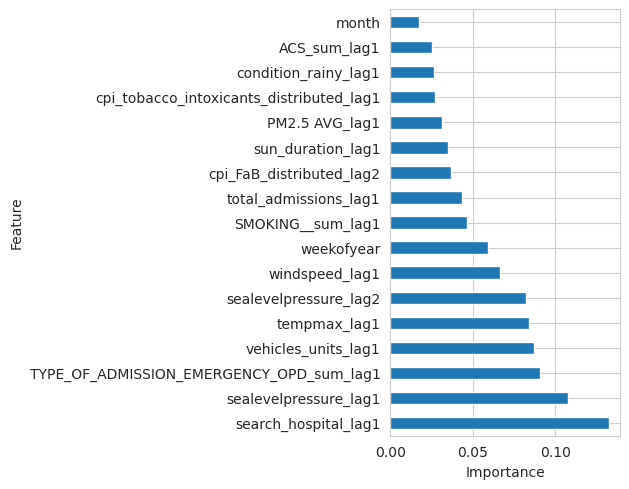

In [37]:
model = performances_all['tuned']['XGBRegressor']['model_fit']
# Get the feature importances
importances = model.feature_importances_

# Convert the importances into a DataFrame
importances_df = pd.DataFrame({
    'Feature': lagged_features_all,
    'Importance': importances
})

# Sort the DataFrame by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(18, 10))
# Plot the importances
importances_df.plot(kind='barh', x='Feature', y='Importance', legend=False)
#plt.title('Feature Importances Final Model')
plt.tight_layout()  # Adjust layout

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig('df_all_feature_importances.jpg', format='jpg', dpi=300)
plt.show()


# 6 Stacking Regressor

In [38]:
from sklearn.ensemble import StackingRegressor

def train_stack_model(df, key, features, final_estimator=None):
    estimators = []
    # Create pipelines for each model
    for model_config in configs[key]['models']:
        model_class = model_config['model']
        model_name = model_class.__name__
        if model_config['model'].__name__ in ['XGBRegressor',  'KNearestNeighbor']:
            params = model_config.get('best_params', {}).copy()
            estimators.append((model_name, model_class(**params)))

    if final_estimator == None:
        for model_config in configs[key]['models']:
            if model_config['model'].__name__ == 'Ridge':      
                final_estimator = Ridge(**model_config.get('best_params', {}))
                break

    stacking_regressor = StackingRegressor(estimators=estimators,
                                           final_estimator=final_estimator)

    performance_dict = train_simple_model(df, features, 'total_admissions', stacking_regressor)
    
    performance_dict['estimators'] = estimators
    
    return performance_dict

## 6.2 Stacking Regressor (all features)

In [39]:
performance_dict = train_stack_model(df_all, 'df_all', lagged_features_all)
performances_all['tuned']['StackingRegressor'] = performance_dict 

Performance for model StackingRegressor:

Test MAE: 14.08306884765625
Train MAE: 12.287530687120226
Test MAPE: 0.08466370599632393
Train MAPE: 0.10243016281512855
Test RMSE: 18.450648039055956
Train RMSE: 16.598533751591702
-------------------------------------------------------------------------


## 6.2 Stacking Regressor (cda features)

In [40]:
performance_dict = train_stack_model(df_cda, 'df_cda', lagged_features_cda)
performances_cda['tuned']['StackingRegressor'] = performance_dict 

Performance for model StackingRegressor:

Test MAE: 13.707191103980655
Train MAE: 11.920217255015432
Test MAPE: 0.08364911663218681
Train MAPE: 0.09819488468248132
Test RMSE: 17.166332813506983
Train RMSE: 16.002029931327627
-------------------------------------------------------------------------


# 7 Voting Regressor

In [41]:
from sklearn.ensemble import VotingRegressor
def train_voting_regressor(source_dict, df, features, weights=[0.4,0.2,0.2,0.2], target='total_admissions', post=True):
    
    params1 = source_dict['tuned']['XGBRegressor']['best_params'].copy()
    params2 = source_dict['tuned']['KNeighborsRegressor']['best_params'].copy()
    params3 = source_dict['tuned']['SVR']['best_params'].copy()
        
    # Determine Splitpoint for Train Size
    split_point = create_split_point(df, split_ratio=.8)

    # Split the data
    X_train, X_test = df[features][:split_point], df[features][split_point:]
    y_train, y_test = df[target][:split_point], df[target][split_point:]

    # not strictly necessary but removes warning during optuna tuning
    y_train, y_test = y_train.squeeze(), y_test.squeeze()
    
    scaler=MinMaxScaler()
    
    # Scale the features
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Combine the models using VotingRegressor
    weights = weights
    voting_model = VotingRegressor([('XGBRegressor', XGBRegressor(**params1)), ('KNeighborsRegressor', KNeighborsRegressor(**params2)), ('SVR', SVR(**params3))], weights=weights)
    voting_model.fit(X_train, y_train)  
    
    y_pred_test = voting_model.predict(X_test)
    y_pred_train = voting_model.predict(X_train)
    
    # Evaluate on test set
    mae_test, rmse_test, mape_test = evaluate_model(y_test, y_pred_test)

    # Evaluate on train set
    mae_train, rmse_train, mape_train = evaluate_model(y_train, y_pred_train)
                                   
# Calculate residuals
    residuals_test = y_test.values - y_pred_test
    residuals_train = y_train.values - y_pred_train
                                   
    # Store the metrics in a dictionary
    performance_dict = {
            'test_mae': mae_test,
            'train_mae': mae_train,
            'test_mape': mape_test,
            'train_mape': mape_train,  
            'test_rmse': rmse_test,
            'train_rmse': rmse_train,
            'predicts_test': y_pred_test,
            'actuals_test': y_test.values, 
            'predicts_train': y_pred_train,
            'actuals_train': y_train.values,    
    }
    
    if post == True:
        print(f"Performance:")
        print()
        print(f"Test MAE: {mae_test}")
        print(f"Train MAE: {mae_train}")
        print(f"Test MAPE: {mape_test}")
        print(f"Train MAPE: {mape_train}")
        print(f"Test RMSE: {rmse_test}")
        print(f"Train RMSE: {rmse_train}")
        print("-------------------------------------------------------------------------")

    return performance_dict


In [42]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Set a random seed for reproducibility
np.random.seed(0)

# Define the objective function
def objective(trial, performances_dict, df, features):
    # Define the weights
    weights = [trial.suggest_float('weight1', 0, 1), trial.suggest_float('weight2', 0, 1), trial.suggest_float('weight3', 0, 1)]
    
    # Normalizing the weights so they sum to 1
    total = sum(weights)
    weights = [weight / total for weight in weights]
    
    performance_dict = train_voting_regressor(performances_dict, df, features, weights=weights, post=False)
    
    test_score = performance_dict['test_mape']
    #train_score = performance_dict['train_mape']
    #overfit_penalty = abs(train_score / test_score - 1)
    
    #final_score = test_score * (1 + overfit_penalty)
    
    return test_score#final_score 

def tune_voting_regressor(dict_type, df_all, features):
    # Create the study and run the optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, performances_all, df_all, features), n_trials=1000)
    best_weights_raw = study.best_params
    total = sum(best_weights_raw.values())
    best_weights_normalized = {k: v / total for k, v in best_weights_raw.items()}
    print('Best weights found: ', best_weights_normalized)
    performance_dict = train_voting_regressor(performances_all, df_all, features, weights=list(best_weights_normalized.values()))
    performance_dict['best_params'] = best_weights_normalized
    return performance_dict



## 7.1 Tuning Voting Regressor (all features)

In [43]:
performance_dict = tune_voting_regressor(performances_all, df_all, lagged_features_all)
performances_all['tuned']['VotingRegressor'] = performance_dict

Best weights found:  {'weight1': 0.9814935263268888, 'weight2': 0.01850168526311172, 'weight3': 4.788409999571812e-06}
Performance:

Test MAE: 11.686390981337233
Train MAE: 9.457951864795486
Test MAPE: 0.0737818012165565
Train MAPE: 0.0776507803443764
Test RMSE: 15.671104682514601
Train RMSE: 12.334824924748196
-------------------------------------------------------------------------


## 7.2 Tuning Voting Regressor (cda features)

In [44]:
performance_dict = tune_voting_regressor(performances_cda, df_cda, lagged_features_cda)
performances_cda['tuned']['VotingRegressor'] = performance_dict

Best weights found:  {'weight1': 0.9272854603880256, 'weight2': 0.0002958965554973313, 'weight3': 0.07241864305647712}
Performance:

Test MAE: 13.29819221413711
Train MAE: 10.736785215079637
Test MAPE: 0.08222535608648637
Train MAPE: 0.08873685068270133
Test RMSE: 18.206156184245444
Train RMSE: 13.844123233469059
-------------------------------------------------------------------------


# 6. LSTM

In [45]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras_tuner import HyperModel, RandomSearch


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [46]:
# create deep copy
df = df_adm.copy()

# Set target and features
target = 'total_admissions'
features_all = ['search_hospital',
                 'visibility',
                 'PM2.5 AVG',
                 'sealevelpressure',
                 'condition_rainy',
                 'ACS_sum',
                 'SMOKING__sum',
                 'tempmax',
                 'windspeed',
                 'sun_duration',
                 'cpi_tobacco_intoxicants_distributed',
                 'vehicles_units',
                 'TYPE_OF_ADMISSION_EMERGENCY_OPD_sum',
                 'cpi_FaB_distributed',]

features_cda = ['tempmax',
                 'sealevelpressure',
                 'sun_duration',
                 'search_hospital',
                 'PM2.5 AVG',
                 'windspeed',
                 'cpi_tobacco_intoxicants_distributed',
                 'vehicles_units',
                 'cpi_FaB_distributed',
                 'condition_rainy']




In [47]:
def create_train_test(df, features, target, split_ratio=0.8, time_steps=1):
    # Split the data
    split_point = create_split_point(df, split_ratio)
    train = df.iloc[:split_point].copy()
    test = df.iloc[split_point + 1:].copy()

    # Scale features to between 0 and 1
    scaler = MinMaxScaler()
    train.loc[:, features] = scaler.fit_transform(train[features])
    test.loc[:, features] = scaler.transform(test[features])

    # Create dataset with time steps
    X_train, y_train = create_dataset(train[features], train[target], time_steps)
    X_test, y_test = create_dataset(test[features], test[target], time_steps)

    return X_train, y_train, X_test, y_test

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


In [48]:
X_train_all, y_train_all, X_test_all, y_test_all = create_train_test(df, features_all, target, time_steps=2)
X_train_cda, y_train_cda, X_test_cda, y_test_cda = create_train_test(df, features_cda, target, time_steps=2)

In [49]:
class LSTMHyperModel(HyperModel):

    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        num_layers = hp.Int('num_layers', 1, 3)
        for i in range(num_layers):  # Tuning the number of layers
            return_sequences = i != num_layers - 1  # Return sequences for all but the last LSTM layer
            model.add(
                LSTM(
                    units=hp.Int('units_' + str(i), 30, 100, step=10, default=50),
                    activation=hp.Choice('activation_' + str(i), ['relu', 'tanh', 'sigmoid']),  # Tuning the activation function
                    dropout=hp.Float('dropout_' + str(i), 0, 1, step=0.1),  # Tuning the dropout rate
                    input_shape=self.input_shape if i == 0 else (1,),
                    return_sequences=return_sequences
                )
            )
        model.add(Dense(1))
        model.compile(
            optimizer=hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop']),  # Tuning the optimizer
            loss='mse'
        )
        return model



def train_lstm_model(X_train, y_train, X_test, y_test, project_name):
    early_stopping_monitor = EarlyStopping(patience=4)

    input_shape=(X_train.shape[1], X_train.shape[2])
    hypermodel = LSTMHyperModel(input_shape=input_shape)

    tuner = RandomSearch(
        hypermodel,
        objective='val_loss',
        max_trials=60,
        executions_per_trial=2,
        seed=42,
        project_name=project_name
        
    )

    tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=100)[0]

    # Build the model with the optimal hyperparameters and train it on the data
    model = tuner.hypermodel.build(best_hps)

    early_stopping_monitor = EarlyStopping(patience=3)

    history = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test), 
                        epochs=50, 
                        callbacks=[early_stopping_monitor],
                        verbose=2)

    # Generate predictions for the test data
    y_pred_test = model.predict(X_test)

    # Generate predictions for the test data
    y_pred_train = model.predict(X_train)

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    print('Test: Root Mean Squared Error: {}'.format(rmse))
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    print('Train: Root Mean Squared Error: {}'.format(rmse_train))

    # Compute MAE
    mae = mean_absolute_error(y_test, y_pred_test)
    print('Test: Mean Absolute Error: {}'.format(mae))
    mae_train = mean_absolute_error(y_train, y_pred_train)
    print('Train: Mean Absolute Error: {}'.format(mae_train))
    
    # Compute MAPE
    mape = mean_absolute_percentage_error(y_test, y_pred_test)
    print('Test: Mean Absolute Error: {}'.format(mae))
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    print('Train: Mean Absolute Error: {}'.format(mae_train))
    
    performance_dict = {
        'model': model,
        'history': history,
        'test_rmse': rmse,
        'train_rmse': rmse,
        'test_mae': mae,
        'train_mae': mae_train,
        'test_mape': mape,
        'train_mape': mape_train,
        'predicts_test' : y_pred_test,
        'actuals_test' : y_test,
        'predicts_train': y_pred_train,
        'actuals_train': y_train,
    }
    
    return performance_dict


## 7.1 Tuning LSTM (all features)

In [50]:
performance_dict = train_lstm_model(X_train_all, y_train_all, X_test_all, y_test_all, 'project_all')

performances_all['tuned']['LSTM'] = performance_dict

Trial 60 Complete [00h 00m 35s]
val_loss: 677.0654296875

Best val_loss So Far: 302.8584747314453
Total elapsed time: 00h 18m 34s
Epoch 1/50
3/3 - 3s - loss: 17144.4590 - val_loss: 8604.4668 - 3s/epoch - 948ms/step
Epoch 2/50
3/3 - 0s - loss: 2446.1421 - val_loss: 1174.5940 - 43ms/epoch - 14ms/step
Epoch 3/50
3/3 - 0s - loss: 747.1453 - val_loss: 938.9817 - 43ms/epoch - 14ms/step
Epoch 4/50
3/3 - 0s - loss: 749.2152 - val_loss: 933.7232 - 40ms/epoch - 13ms/step
Epoch 5/50
3/3 - 0s - loss: 744.2053 - val_loss: 890.8145 - 43ms/epoch - 14ms/step
Epoch 6/50
3/3 - 0s - loss: 734.2826 - val_loss: 1351.0206 - 40ms/epoch - 13ms/step
Epoch 7/50
3/3 - 0s - loss: 728.1739 - val_loss: 1184.3286 - 43ms/epoch - 14ms/step
Epoch 8/50
3/3 - 0s - loss: 721.4714 - val_loss: 1174.4861 - 45ms/epoch - 15ms/step
3/3 [==============================] - 0s 3ms/step
Test: Root Mean Squared Error: 34.270775552066034
Train: Root Mean Squared Error: 26.648230842757137
Test: Mean Absolute Error: 28.535280015733505
T

## 7.2 Tuning LSTM (cda features)

In [51]:
performance_dict = train_lstm_model(X_train_cda, y_train_cda, X_test_cda, y_test_cda, 'project_cda')

performances_cda['tuned']['LSTM'] = performance_dict

Trial 60 Complete [00h 00m 24s]
val_loss: 823.1036376953125

Best val_loss So Far: 329.2940368652344
Total elapsed time: 00h 18m 40s
Epoch 1/50
3/3 - 3s - loss: 17259.2812 - val_loss: 10516.7695 - 3s/epoch - 909ms/step
Epoch 2/50
3/3 - 0s - loss: 3128.0801 - val_loss: 1449.1932 - 37ms/epoch - 12ms/step
Epoch 3/50
3/3 - 0s - loss: 745.9507 - val_loss: 1299.1429 - 38ms/epoch - 13ms/step
Epoch 4/50
3/3 - 0s - loss: 742.8730 - val_loss: 1010.9464 - 38ms/epoch - 13ms/step
Epoch 5/50
3/3 - 0s - loss: 724.4612 - val_loss: 1630.7852 - 37ms/epoch - 12ms/step
Epoch 6/50
3/3 - 0s - loss: 772.1805 - val_loss: 955.0579 - 41ms/epoch - 14ms/step
Epoch 7/50
3/3 - 0s - loss: 743.2365 - val_loss: 1148.6921 - 41ms/epoch - 14ms/step
Epoch 8/50
3/3 - 0s - loss: 730.5314 - val_loss: 989.8008 - 41ms/epoch - 14ms/step
Epoch 9/50
3/3 - 0s - loss: 716.8480 - val_loss: 973.1343 - 36ms/epoch - 12ms/step
3/3 [==============================] - 0s 3ms/step
Test: Root Mean Squared Error: 31.19510532951188
Train: Root

# 8. Performance Overview & Analysis Best Model

In [52]:
def create_overview(my_dict, dict_version):
    # Initialize an empty list to store rows
    data = []

    # Iterate through the dictionary
    for model_type, models in my_dict.items():
        # Check if models is a dictionary and not "untuned"
        if isinstance(models, dict) and model_type != "untuned":
            # Check if the model_type is "tuned"
            if model_type == "tuned":
                # Iterate through the nested models
                for model_name, model_data in models.items():
                    # Extract the performance indicators and best params if available
                    row = {
                        "model": model_name,
                        "mae_test": model_data.get("test_mae"),
                        "mape_test": model_data.get("test_mape"),
                        "rmse_test": model_data.get("test_rmse"),
                        "mae_train": model_data.get("train_mae"),
                        "mape_train": model_data.get("train_mape"),
                        "rmse_train": model_data.get("train_rmse"),
                        "best_params": model_data.get("best_params")
                    }
                    data.append(row)
            else:
                # Extract the performance indicators and best params if available
                row = {
                    "model": model_type,
                    "mae_test": models.get("test_mae") or models.get("mae"),
                    "mape_test": models.get("test_mape") or models.get("mape"),
                    "rmse_test": models.get("test_rmse") or models.get("rmse"),
                    "mae_train": models.get("train_mae"),
                    "mape_train": models.get("train_mape"),
                    "rmse_train": models.get("train_rmse"),
                    "best_params": models.get("best_params")
                }
                data.append(row)

    # Create DataFrame
    df = pd.DataFrame(data)

    # Reorder columns
    column_order = ["model", "mape_test", "mape_train", "mae_test", "mae_train", "rmse_test", "rmse_train", "best_params"]
    df = df[column_order]
    
    # Sort dataframe by mape_test in ascending order
    df = df.sort_values('mape_test', ascending=True)
    
    df.to_excel(f'{dict_version}_overview.xlsx', index=False)

    return df


## 8.1 Overview Models

In [53]:
overview_all = create_overview(performances_all, 'performances_all')
overview_all

,model,mape_test,mape_train,mae_test,mae_train,rmse_test,rmse_train,best_params
10,VotingRegressor,0.073782,0.077651,11.686391,9.457952,15.671105,12.334825,"{'weight1': 0.9814935263268888, 'weight2': 0.0..."
8,XGBRegressor,0.073839,0.076832,11.659373,9.363924,15.690921,12.214227,"{'n_estimators': 100, 'max_depth': 1, 'learnin..."
9,StackingRegressor,0.084664,0.102430,14.083069,12.287531,18.450648,16.598534,None
5,SVR,0.099872,0.098999,16.155014,11.412086,20.168633,19.788126,"{'kernel': 'poly', 'degree': 6, 'gamma': 0.032..."
6,KNeighborsRegressor,0.103565,0.132299,17.208333,15.791667,22.874577,22.701035,"{'n_neighbors': 8, 'weights': 'uniform', 'algo..."
7,RandomForestRegressor,0.103839,0.092770,17.529168,11.069246,23.000355,16.166686,"{'n_estimators': 100, 'max_depth': 9, 'min_sam..."
3,ElasticNet,0.104975,0.127132,17.047382,15.506164,21.302620,22.075678,"{'alpha': 0.6401217713175151, 'l1_ratio': 0.99..."
4,Ridge,0.119492,0.125382,19.850846,15.419183,24.564970,21.781002,"{'alpha': 0.0010049478974808255, 'fit_intercep..."
2,SARIMAX,0.119720,0.185086,19.517915,20.017346,22.803821,30.615630,None
1,ARIMA,0.145647,0.174647,24.562243,20.698530,30.818367,28.760948,None


In [54]:
overview_cda = create_overview(performances_cda, 'performances_cda')
overview_cda

,model,mape_test,mape_train,mae_test,mae_train,rmse_test,rmse_train,best_params
8,XGBRegressor,0.067742,0.068780,10.271428,8.503439,14.063643,10.898055,"{'n_estimators': 110, 'max_depth': 1, 'learnin..."
10,VotingRegressor,0.082225,0.088737,13.298192,10.736785,18.206156,13.844123,"{'weight1': 0.9272854603880256, 'weight2': 0.0..."
9,StackingRegressor,0.083649,0.098195,13.707191,11.920217,17.166333,16.002030,None
7,RandomForestRegressor,0.096347,0.085080,16.079559,10.180115,21.187548,14.679543,"{'n_estimators': 110, 'max_depth': 6, 'min_sam..."
5,SVR,0.108972,0.109475,17.642385,12.578795,21.735300,19.666150,"{'kernel': 'poly', 'degree': 4, 'gamma': 0.095..."
3,ElasticNet,0.109811,0.133417,17.942709,16.142622,22.353270,22.601459,"{'alpha': 1.0129856673153965, 'l1_ratio': 0.99..."
4,Ridge,0.118530,0.131986,19.214606,16.062376,22.743241,22.297294,"{'alpha': 0.5177907232730414, 'fit_intercept':..."
6,KNeighborsRegressor,0.120117,0.142035,20.257143,17.149383,26.952904,24.208663,"{'n_neighbors': 10, 'weights': 'uniform', 'alg..."
2,SARIMAX,0.138130,0.194288,22.520733,20.303126,25.904059,36.044329,None
11,LSTM,0.145234,0.164048,24.806177,19.510275,31.195105,31.195105,None


## 8.2 Overview Predictions vs. Actuals on Test Set

In [55]:
def plot_predictions(performance_dict, dict_type):
    # Prepare models to plot
    models_to_plot = {}
    if 'ARIMA' in performance_dict:
        models_to_plot['ARIMA'] = performance_dict['ARIMA']
    if 'SARIMAX' in performance_dict:
        models_to_plot['SARIMAX'] = performance_dict['SARIMAX']
    if 'tuned' in performance_dict:
        for model_name, model_info in performance_dict['tuned'].items():
            models_to_plot[model_name] = model_info

    # Count how many models we have
    num_models = len(models_to_plot)

    # Decide how many columns and rows we want in our plot grid
    num_cols = 2
    num_rows = num_models // num_cols if num_models % num_cols == 0 else num_models // num_cols + 1

    # Create a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.ravel()  # Flatten the axes array to make it easier to iterate over

    # For each model in the models_to_plot dictionary
    for i, (model_name, model_info) in enumerate(models_to_plot.items()):
        # Get the axis for this plot
        ax = axes[i]

        # Get the predictions and actuals for this model
        predicts = model_info.get('predicts_test', [])
        actuals = model_info.get('actuals_test', [])

        # Plot the actuals and predictions on this axis
        ax.plot(range(len(predicts)), predicts, label='Predictions')
        ax.plot(range(len(actuals)), actuals, label='Actuals', color='orange')

        # Set the title of the plot to the model's name and add a legend
        ax.set_title(model_name)
        ax.legend()

        text_str = (f"MAE:          MAPE:\n"
            f"tr: {model_info.get('train_mae', 'N/A'):.2f}    tr: {model_info.get('train_mape', 'N/A'):.2f}\n"
            f"ts: {model_info.get('test_mae', 'N/A'):.2f}    ts: {model_info.get('test_mape', 'N/A'):.2f}\n\n"
            f"RMSE:\n"
            f"tr: {model_info.get('train_rmse', 'N/A'):.2f}\n"
            f"ts: {model_info.get('test_rmse', 'N/A'):.2f}")

        ax.text(0.01, 0.98, text_str, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', bbox=dict(boxstyle='round', 
                                                   facecolor='white', 
                                                   alpha=1, 
                                                   edgecolor='lightgrey',))

    # If the number of models isn't exactly divisible by the number of columns
    # there will be extra, empty subplots. This removes those.
    if num_models % num_cols != 0:
        for j in range(i+1, num_rows*num_cols):
            fig.delaxes(axes[j])  # Remove the extra sub-plots

    # Finally, show the plot
    plt.tight_layout()
    plt.savefig(f'{dict_type}_graphs.jpg', format='jpg', dpi=300)
    plt.show()


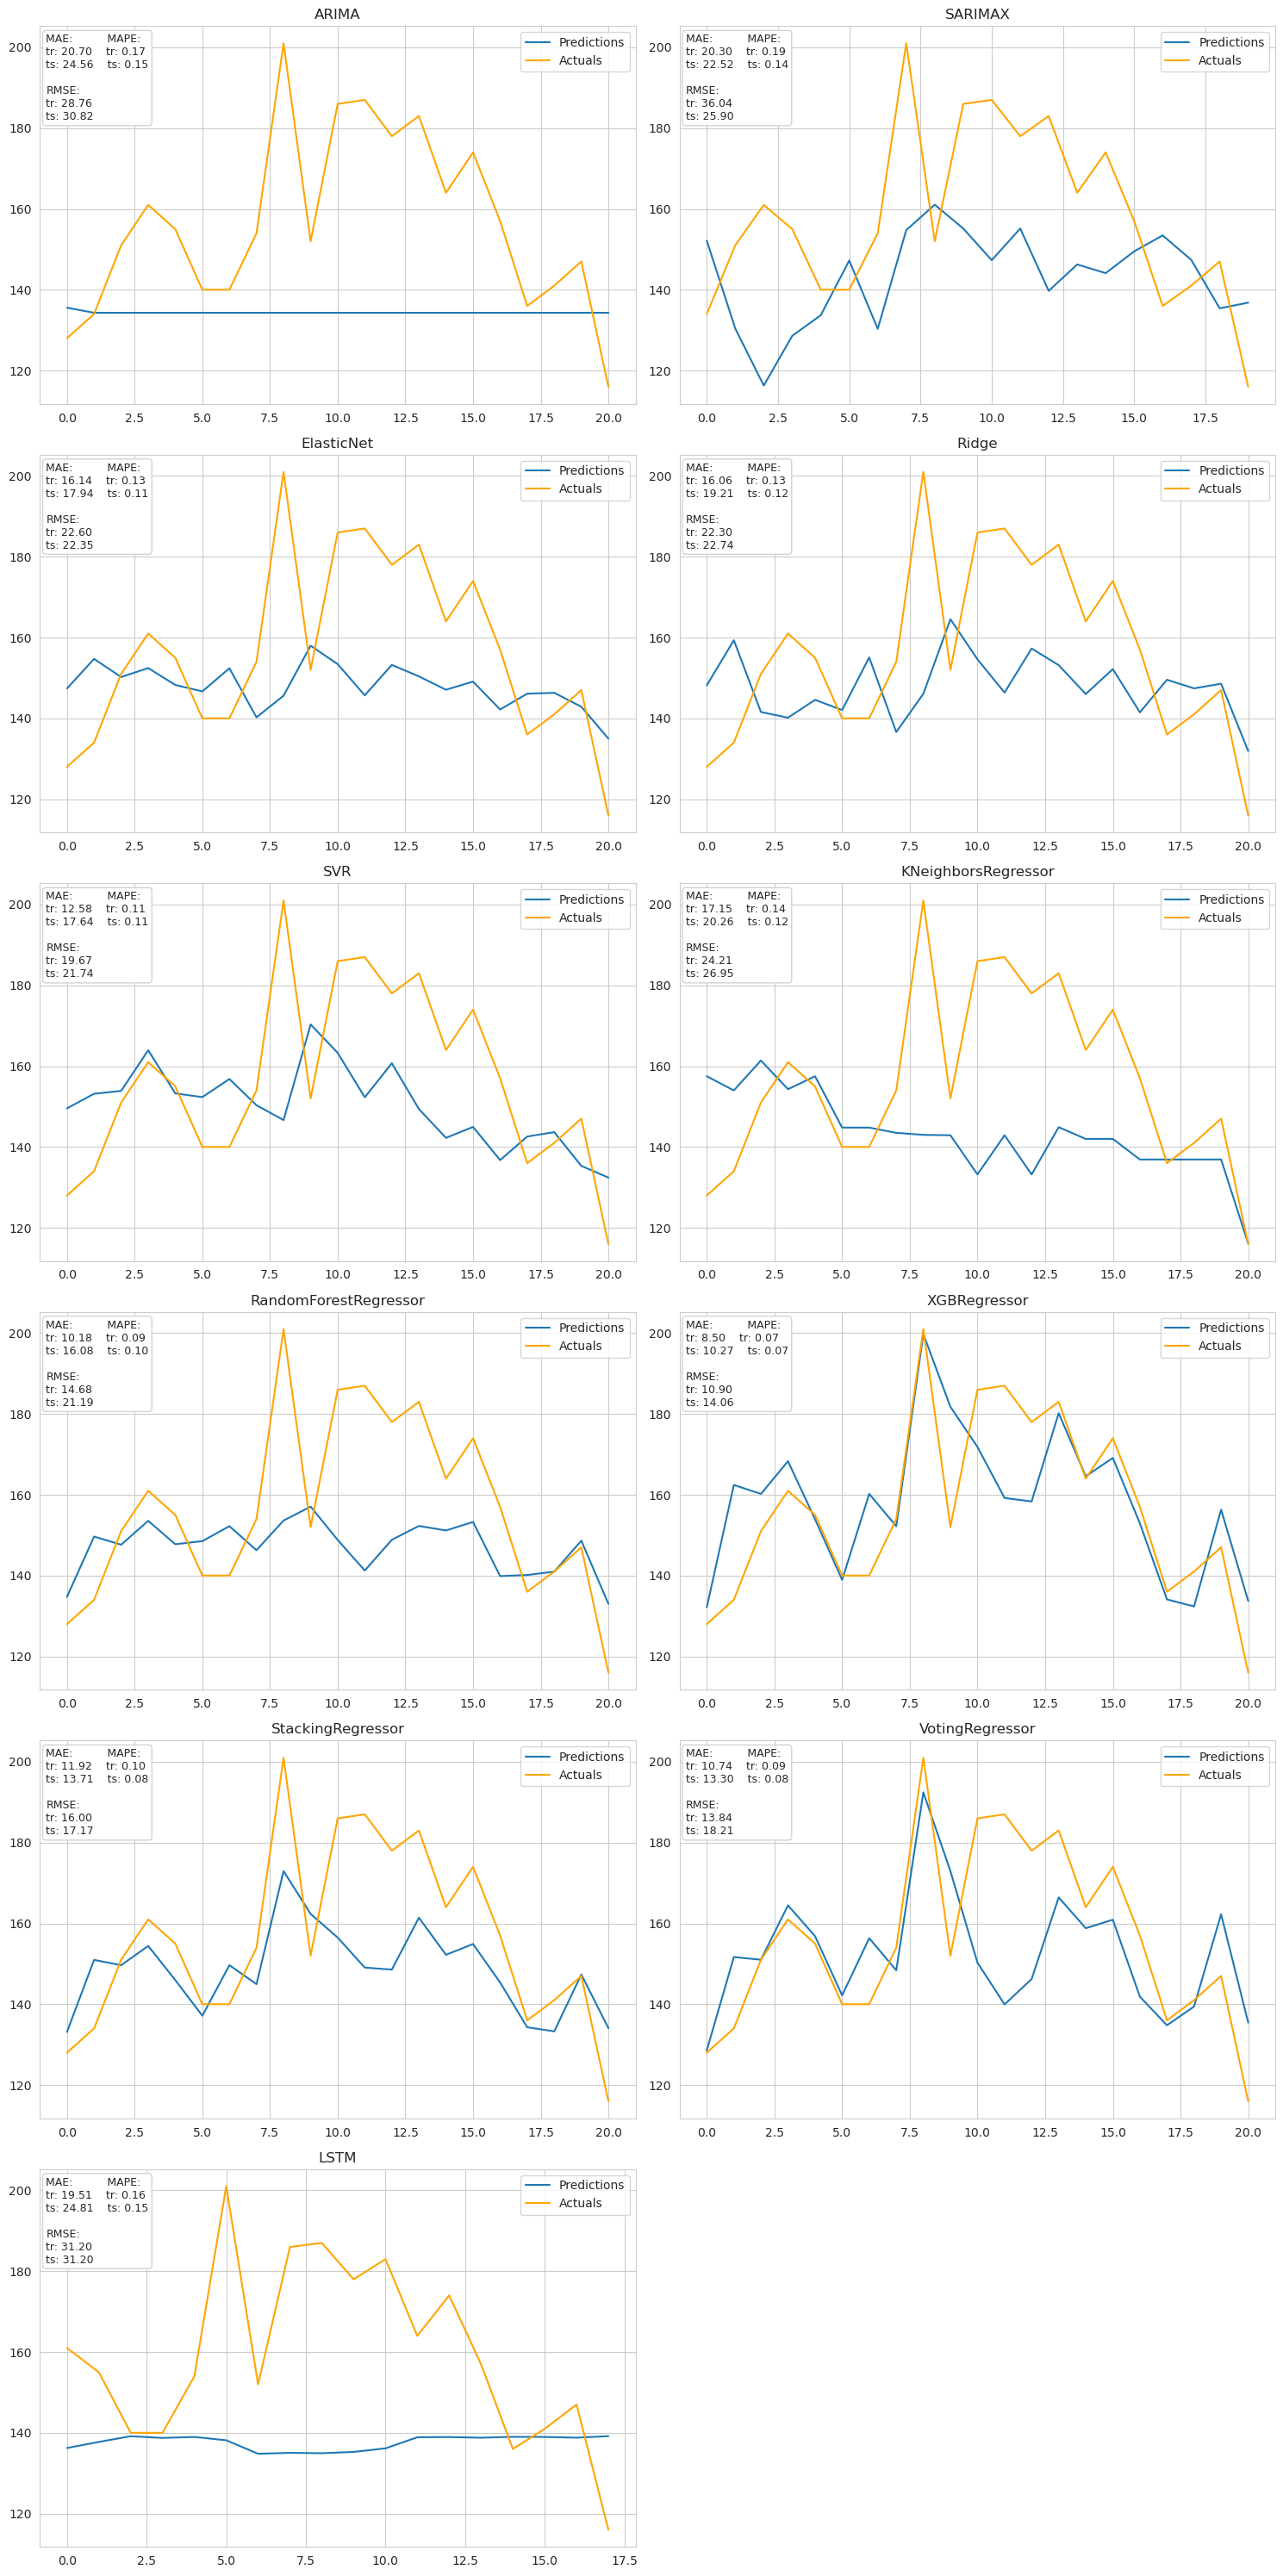

In [56]:
plot_predictions(performances_cda, 'performances_cda')

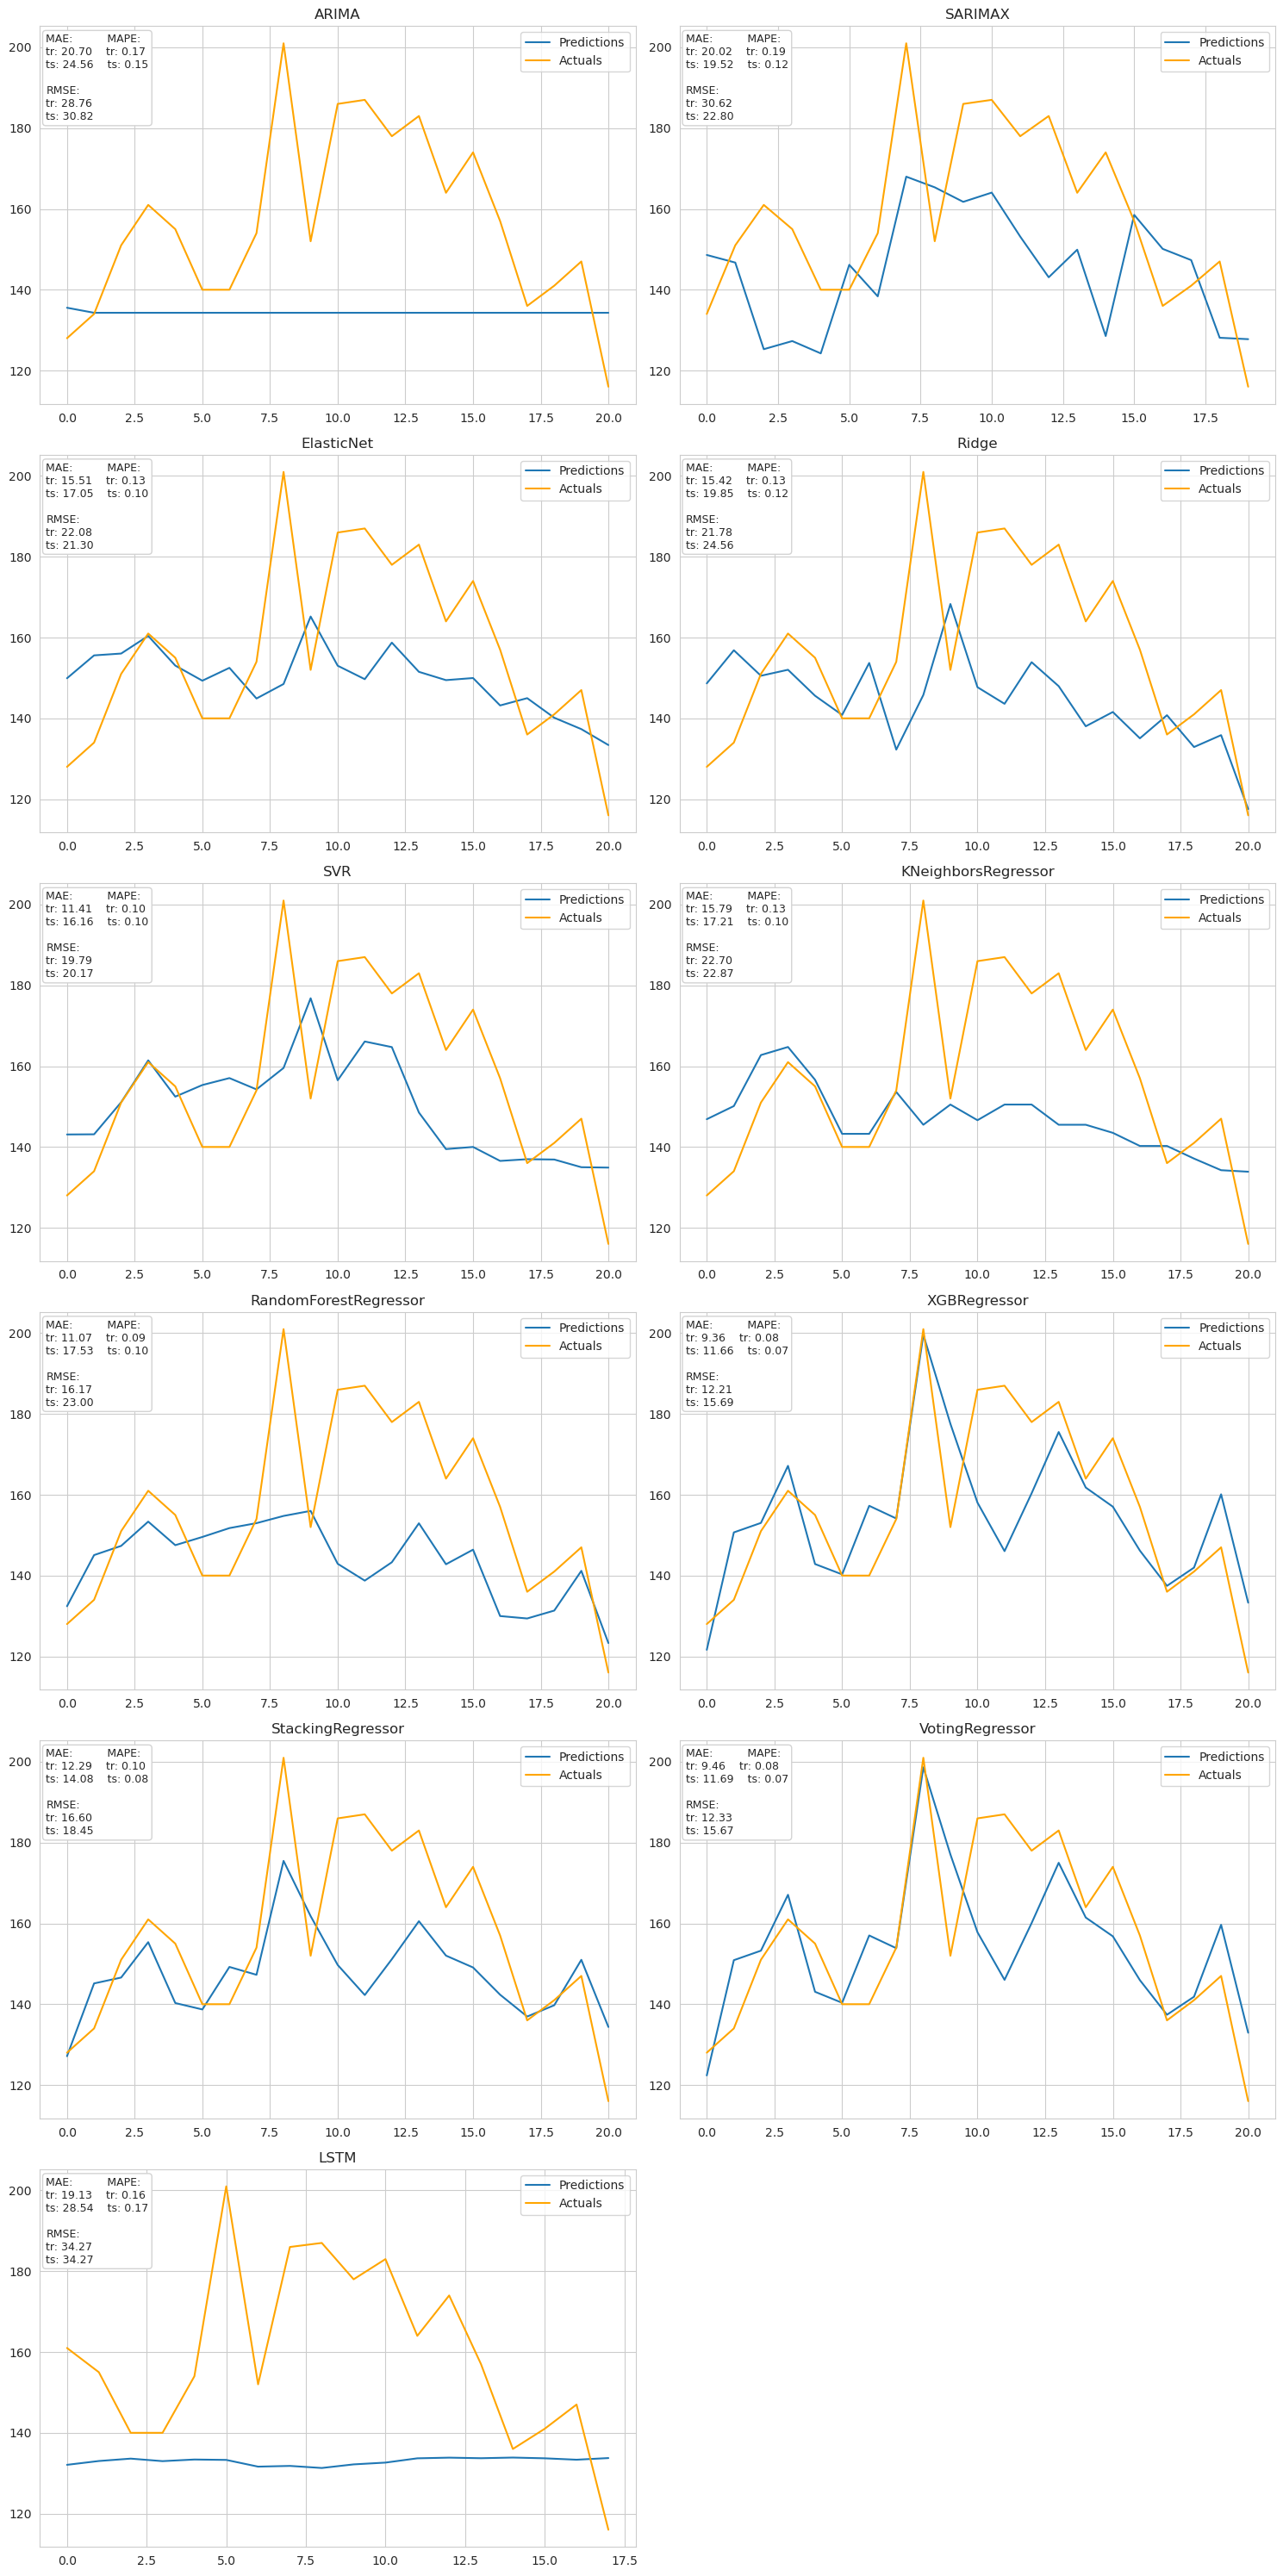

In [57]:
plot_predictions(performances_all, 'performances_all')

In [58]:
df_perf = pd.read_csv('/kaggle/input/performances-cda-overview/performances_cda_overview.csv')

In [59]:
from matplotlib.dates import MonthLocator, DateFormatter
def plot_predictions_long(performance_dict, dict_type):
    # Prepare models to plot
    models_to_plot = {}
    if 'ARIMA' in performance_dict:
        models_to_plot['ARIMA'] = performance_dict['ARIMA']
    if 'SARIMAX' in performance_dict:
        models_to_plot['SARIMAX'] = performance_dict['SARIMAX']
    if 'tuned' in performance_dict:
        for model_name, model_info in performance_dict['tuned'].items():
            models_to_plot[model_name] = model_info
    
    # Sort the models by performance and select the top 5
    models_to_plot = dict(sorted(models_to_plot.items(), key=lambda item: item[1]['test_mape'])[:5])

    # Create a single plot
    fig, ax = plt.subplots(figsize=(16, 5))

    # Define a list of colors for the models
    colors = ['orange', 'blue', 'magenta', 'cyan', 'black']

    # For each model in the models_to_plot dictionary
    for i, (model_name, model_info) in enumerate(models_to_plot.items()):
        # Get the predictions and actuals for this model
        train_predicts = model_info.get('predicts_train', [])
        test_predicts = model_info.get('predicts_test', [])
        
        # Plot the actuals and predictions on this axis
        #ax.plot(range(len(train_predicts)), train_predicts, label=f'{model_name}', linewidth=1, color=colors[i % len(colors)])
        #ax.plot(range(len(train_predicts), len(train_predicts) + len(test_predicts)), test_predicts, linewidth=1, alpha=1, color=colors[i % len(colors)])
        
        # Plot the actuals and predictions on this axis using the datetime index for x-values
        ax.plot(df_cda.index[:len(train_predicts)], train_predicts, label=f'{model_name}', linewidth=1, color=colors[i % len(colors)])
        ax.plot(df_cda.index[len(train_predicts):len(train_predicts) + len(test_predicts)], test_predicts, linewidth=1, alpha=1, color=colors[i % len(colors)])
    
        # Set the title of the plot to the model's name and add a legend
        ax.set_title('Model Top 5 Comparison ')
        ax.legend()

    # Get the actuals for the plot (assuming they are the same for all models)
    model_info = next(iter(models_to_plot.values()))  # Get the info for the first model
    train_actuals = model_info.get('actuals_train', [])
    test_actuals = model_info.get('actuals_test', [])
    
    
    ax.set_xlim(df_cda.index.min(), df_cda.index.max())

    # Plot the actuals once, outside of the loop
    #ax.plot(range(len(train_actuals) + len(test_actuals)), np.concatenate([train_actuals, test_actuals]), label='Actuals', color='black', linestyle='-.', linewidth=.75,)
    # Plot the actuals using the datetime index for x-values
    all_actuals = np.concatenate([train_actuals, test_actuals])
    ax.xaxis.set_major_locator(MonthLocator(interval=2))
    start_date = pd.Timestamp(year=2017, month=4, day=22)
    ax.set_xlim(left=start_date)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    ax.plot(df_cda.index[:len(all_actuals)], all_actuals, label='Actuals', color='black', linestyle='-.', linewidth=.75)
    plt.xlabel('Date')
    plt.ylabel('Hospital Admissions')

    
    # Add a vertical line to separate the training and test sets
    ax.axvline(x=df_cda.index[len(train_actuals)], color='red', linestyle='--')

    ax.legend()
    plt.legend(loc='upper left')



    # Finally, show the plot
    plt.tight_layout()
    plt.savefig(f'{dict_type}_top5_graph.jpg', format='jpg', dpi=300)
    plt.show()


In [60]:
_ = train_simple_model(df_cda, lagged_features_cda, 'total_admissions', XGBRegressor(** {'n_estimators': 110, 'max_depth': 1, 'learning_rate': 0.5080002394591917, 'gamma': 3.081452200521556, 'subsample': 0.9782490128818022, 'colsample_bytree': 0.12455226894662738, 'reg_alpha': 2.407755312003315, 'reg_lambda': 1.4226014204300563}
))


Performance for model XGBRegressor:

Test MAE: 10.271427699497767
Train MAE: 8.503438690562307
Test MAPE: 0.06774189515993363
Train MAPE: 0.06878031950055634
Test RMSE: 14.063642870532465
Train RMSE: 10.898054882885873
-------------------------------------------------------------------------


In [61]:
performances_cda['tuned']['XGBRegressor'] = _

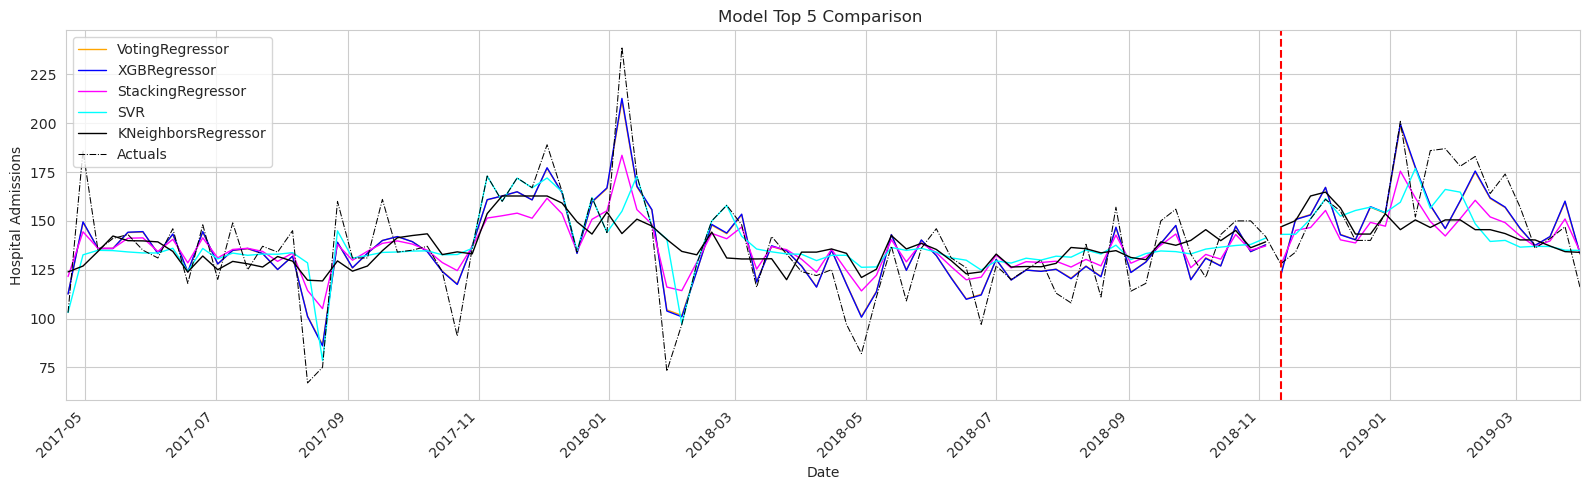

In [62]:
plot_predictions_long(performances_all, 'performances_all')

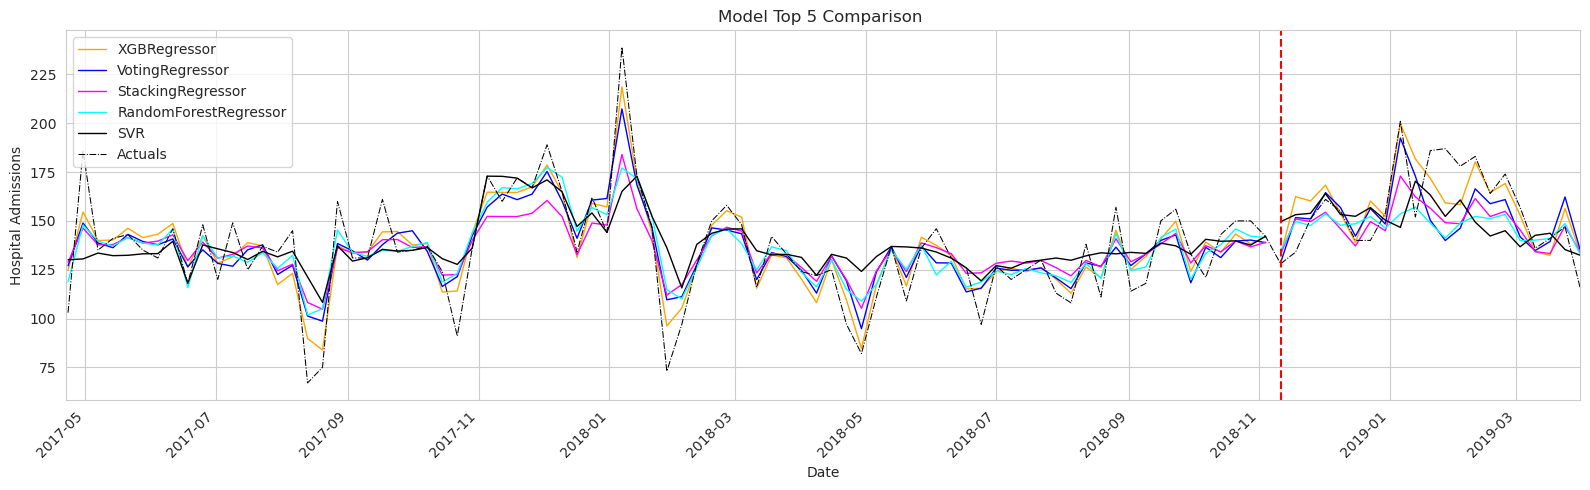

In [63]:
plot_predictions_long(performances_cda, 'performances_cda')

## 8.3 Further Model Evalutation

########## Analysis Best Model (XGBRegressor) ########## 

Summary Statistics Residuals: 
 {'Mean': -1.7987263997395833, 'Median': 1.060943603515625, 'Standard Deviation': 13.948140884317112, 'Skewness': -0.18220455832968457, 'Kurtosis': -0.027804792616039187}

[ 1.00000000e+00  2.48489995e-01 -1.01835151e-01  8.49383600e-02
 -1.50905031e-02  5.14266146e-02  5.35795473e-03  2.10273698e-02
  1.21453335e-02 -4.05072042e-01 -2.68102676e-01 -6.19893981e-02
 -1.12072239e-01 -7.18172847e-04  1.40000513e-02 -7.93113981e-02
 -4.74366677e-02 -3.50444409e-02  7.19208852e-02  1.08209988e-01
  9.15613755e-03]


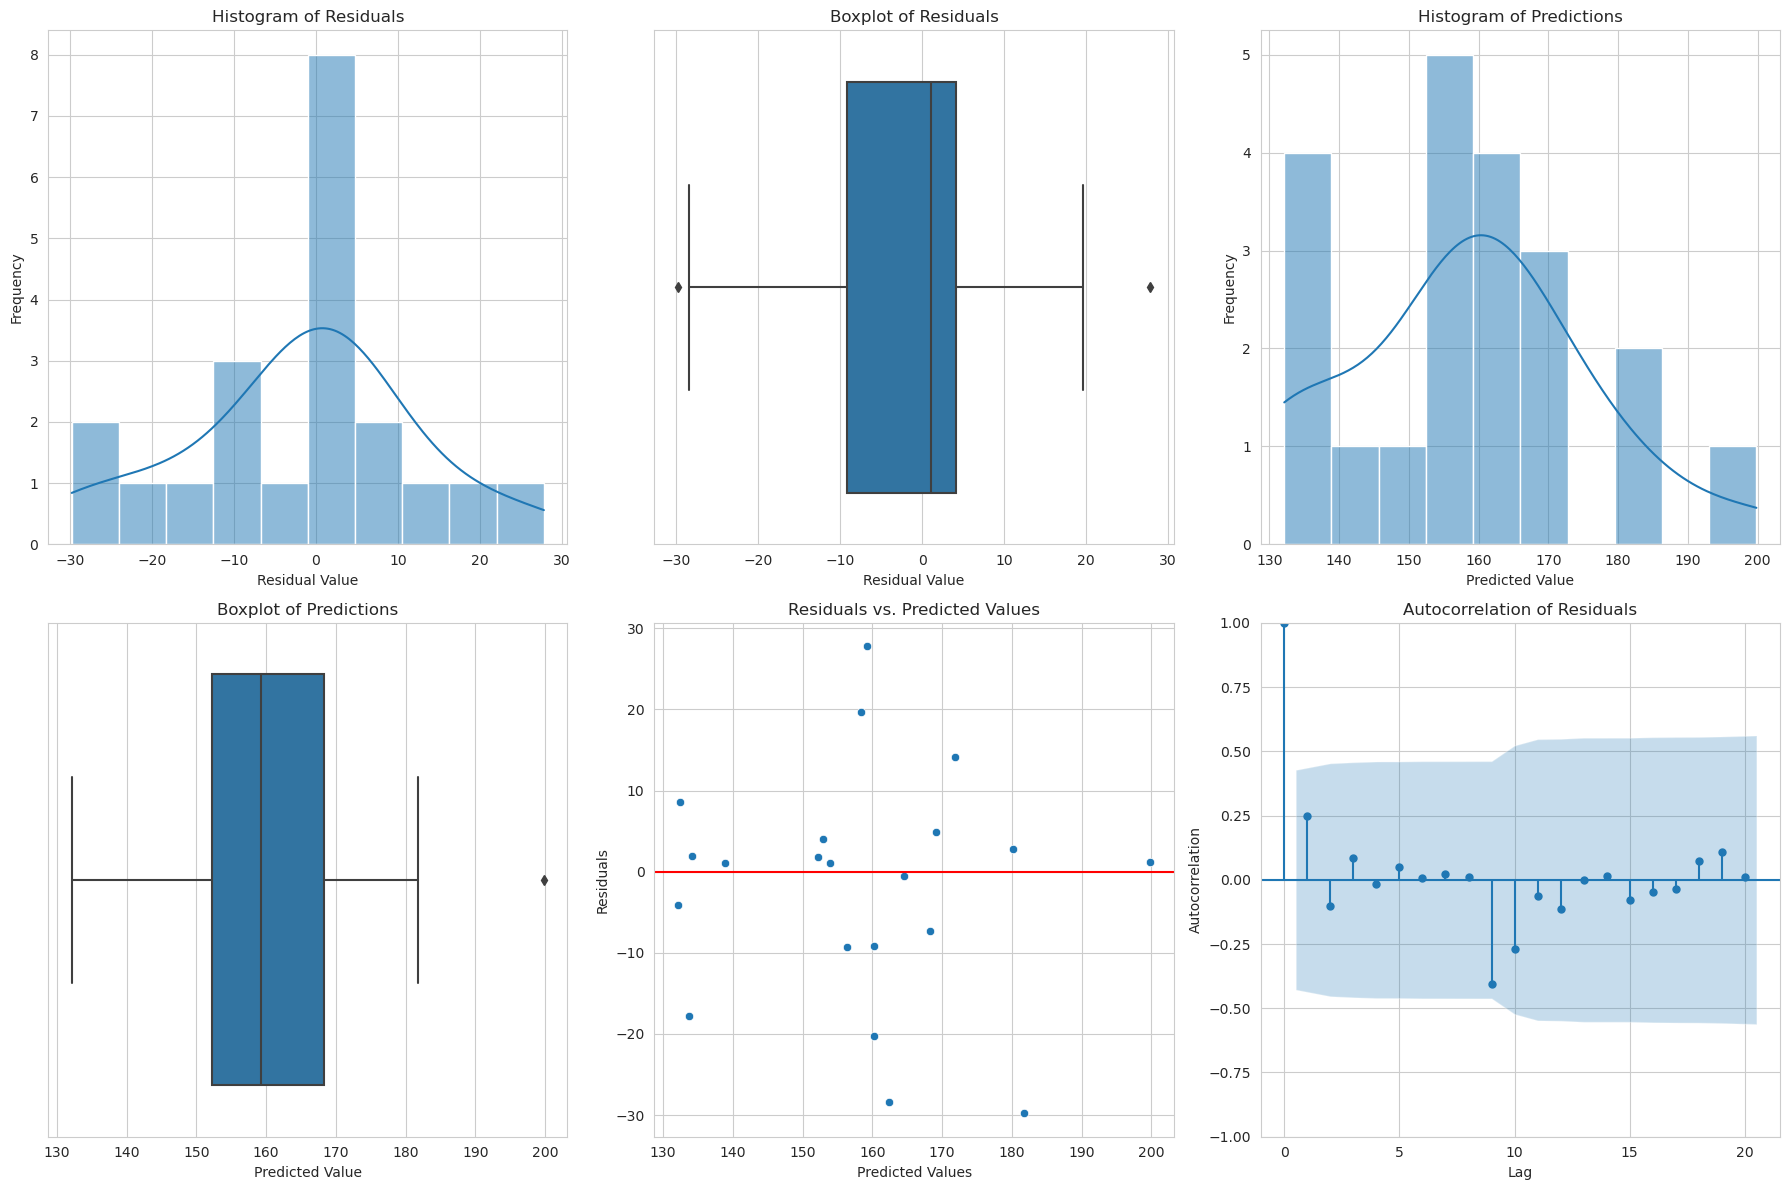

In [64]:
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

residuals_test = performances_cda['tuned']['XGBRegressor']['residuals_test']
predictions_test = performances_cda['tuned']['XGBRegressor']['predicts_test']

# Descriptive statistics for residuals of the tuned model
residuals_test_mean = np.mean(residuals_test)
residuals_test_median = np.median(residuals_test)
residuals_test_std = np.std(residuals_test)
residuals_test_skew = stats.skew(residuals_test)
residuals_test_kurtosis = stats.kurtosis(residuals_test)

residuals_test_stats = {
    "Mean": residuals_test_mean,
    "Median": residuals_test_median,
    "Standard Deviation": residuals_test_std,
    "Skewness": residuals_test_skew,
    "Kurtosis": residuals_test_kurtosis
}

print('########## Analysis Best Model (XGBRegressor) ########## \n')
print(f'Summary Statistics Residuals: \n {residuals_test_stats}\n')
      
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

sns.histplot(residuals_test, bins=10, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Histogram of Residuals')
axs[0, 0].set_xlabel('Residual Value')
axs[0, 0].set_ylabel('Frequency')

sns.boxplot(x=residuals_test, ax=axs[0, 1])
axs[0, 1].set_title('Boxplot of Residuals')
axs[0, 1].set_xlabel('Residual Value')

# Histogram and boxplot for predictions
sns.histplot(predictions_test, bins=10, kde=True, ax=axs[0, 2])
axs[0, 2].set_title('Histogram of Predictions')
axs[0, 2].set_xlabel('Predicted Value')
axs[0, 2].set_ylabel('Frequency')

sns.boxplot(x=predictions_test, ax=axs[1, 0])
axs[1, 0].set_title('Boxplot of Predictions')
axs[1, 0].set_xlabel('Predicted Value')

# Scatter plot of residuals vs. predicted values
sns.scatterplot(x=predictions_test, y=residuals_test, ax=axs[1, 1])
axs[1, 1].set_title('Residuals vs. Predicted Values')
axs[1, 1].set_xlabel('Predicted Values')
axs[1, 1].set_ylabel('Residuals')
axs[1, 1].axhline(y=0, color='r', linestyle='-')  # horizontal line at 0

# Autocorrelation of residuals for the tuned model
plot_acf(residuals_test, lags=20, ax=axs[1, 2])
axs[1, 2].set_title('Autocorrelation of Residuals')
axs[1, 2].set_xlabel('Lag')
axs[1, 2].set_ylabel('Autocorrelation')

# Compute the autocorrelation of the residuals
autocorr_values = acf(residuals_test, nlags=20)

# Print the autocorrelation values
print(autocorr_values)

plt.tight_layout()
plt.savefig(f'residuals_autocorrleation_overview.jpg', format='jpg', dpi=300)
plt.show()





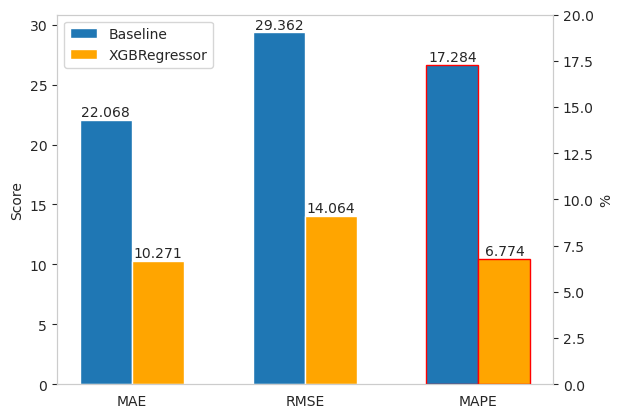

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D  # needed for custom legend

# Define KPIs
kpis = ['mae', 'rmse', 'mape']

# Fetch the performance scores for each KPI and model
baseline_scores = [performances_cda['Baseline'][kpi] for kpi in kpis]
xgbregressor_scores = [performances_cda['tuned']['XGBRegressor'][f'test_{kpi}'] for kpi in kpis]

# Convert MAPE values to percentages
baseline_scores[-1] *= 100
xgbregressor_scores[-1] *= 100

# Define width of a bar
barWidth = 0.3

# Set position of bar on X axis
r1 = np.arange(len(baseline_scores) - 1)
r2 = [x + barWidth for x in r1]
r3 = [len(baseline_scores) - 1]  # New x position for MAPE

fig, ax1 = plt.subplots()

# Make the plot for MAE and RMSE
bar1 = ax1.bar(r1, baseline_scores[:-1], color='tab:blue', width=barWidth, label='Baseline')
bar2 = ax1.bar(r2, xgbregressor_scores[:-1], color='orange', width=barWidth, label='XGBRegressor')

# instantiate a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  
ax2.set_ylabel('%')  # we already handled the x-label with ax1

# plot MAPE on the second y-axis
bar3 = ax2.bar(r3, [baseline_scores[-1]], color='tab:blue', width=barWidth, edgecolor='red')
bar4 = ax2.bar([r + barWidth for r in r3], [xgbregressor_scores[-1]], color='orange', width=barWidth, edgecolor='red')
ax2.set_ylim([0, 20])

def annotate_bars(bars, ax, values):
    for i, bar in enumerate(bars):
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{values[i]:.3f}', ha='center', va='bottom')


annotate_bars(bar1, ax1, baseline_scores[:-1])
annotate_bars(bar2, ax1, xgbregressor_scores[:-1])
annotate_bars(bar3, ax2, [baseline_scores[-1]])
annotate_bars(bar4, ax2, [xgbregressor_scores[-1]])


# Add xticks on the middle of the group bars
ax1.set_ylabel('Score')
ax1.set_xticks([r + barWidth/2 for r in range(len(baseline_scores))])
ax1.set_xticklabels([kpi.upper() for kpi in kpis])

# Define the custom legend for MAPE
red_square = Line2D([0], [0], marker='s', color='w', label='Scaled Error', markerfacecolor='none', markersize=10, markeredgewidth=1.5, markeredgecolor='red')

# Add legends
ax1.legend(loc='upper left')

ax1.grid(False)
ax2.grid(False)

#ax2.legend(handles=[red_square], loc='upper right')  # Adjust position

#plt.title('Performance Comparison: Baseline vs. Final Model')
plt.savefig(f'Performance_Comparison_Baseline_vs_Final_Model.jpg', format='jpg', dpi=300)
plt.show()


/tmp/ipykernel_20/2485272279.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([kpi.upper() for kpi in kpis])


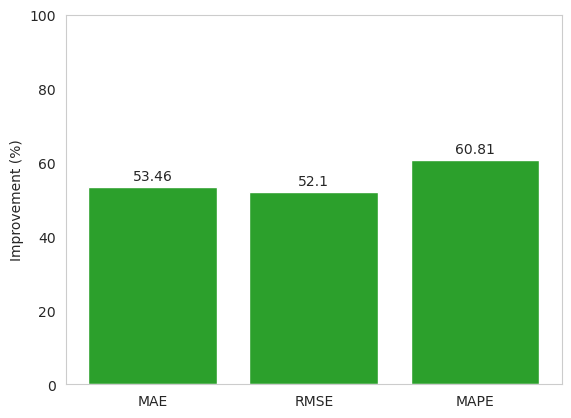

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Define KPIs
kpis = ['mae', 'rmse', 'mape']

# Fetch the performance scores for each KPI and model
baseline_scores = [performances_cda['Baseline'][kpi] for kpi in kpis]
xgbregressor_scores = [performances_cda['tuned']['XGBRegressor'][f'test_{kpi}'] for kpi in kpis]

# Calculate percentage improvement for each KPI
percentage_improvements = [(baseline - xgb) / baseline * 100 for baseline, xgb in zip(baseline_scores, xgbregressor_scores)]

fig, ax = plt.subplots()

# Create bar plot for percentage improvements
bars = plt.bar(kpis, percentage_improvements, color='tab:green')

# Add data value on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, round(yval, 2), ha='center', va='bottom')
    
ax.set_xticklabels([kpi.upper() for kpi in kpis])
ax.set_ylim([0,100])
ax.grid(False)
# Add labels and title
ax.set_ylabel('Improvement (%)')
#plt.title('Percentage Improvement of XGBRegressor over Baseline')
plt.savefig(f'Percentage_Improvement_of_XGBRegressor_over_Baseline.jpg', format='jpg', dpi=300)
plt.grid(False)

plt.show()


# 9. Retrain and Export Best Model

In [67]:
import pickle

def train_final_model(df, features, file_id, modelname, final_params, target='total_admissions',):

    X = df[features]
    y = df['total_admissions']
    
    # Initialize a scaler object 
    scaler = MinMaxScaler()

    # Scale the features
    X = scaler.fit_transform(X)
    
    model = modelname(**final_params)
    
    model.fit(X, y)
    
    # Save the trained model as a pickle file
    with open(f'final_model_{file_id}.pkl', 'wb') as f:
        pickle.dump(model, f)
        
    # Save the scaler object
    with open(f'scaler_{file_id}.pkl', 'wb') as f:
        pickle.dump(scaler, f)
        
    print('Model and Scaler saved successfully!')

    return model, scaler


In [68]:
final_params=performances_cda['tuned']['XGBRegressor']['best_params']
model, scalar = train_final_model(df_cda, lagged_features_cda,  'discard', XGBRegressor, final_params)

KeyError: 'best_params'